In [1]:
import sys  
sys.path.insert(0, '../')

import os
import numpy as np
import GPyOpt
from feature_extraction.loan_struct_reader import LoanStructReader
from feature_extraction.loan_options_maker import LoanOptionsMaker
from feature_extraction.loan_concatenator import LoanConcatenator
from feature_extraction.loan_markuper import LoanMarkuper
from feature_extraction.hist_market_worker import HistMarketDataWorker
from scipy.stats.contingency import margins

import matplotlib.pyplot as plt
import scipy.stats as ss
import itertools
import math

plt.rcParams["axes.labelsize"] = 16. 
plt.rcParams["xtick.labelsize"] = 14. 
plt.rcParams["ytick.labelsize"] = 14. 
plt.rcParams["legend.fontsize"] = 12. 
plt.rcParams["figure.figsize"] = [15., 6.]

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [2]:
PROJECT_PATH = os.path.dirname(os.getcwd())
DOMAIN = [{'name': 'var_1', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_3', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_4', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_5', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_6', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_7', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_8', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_9', 'type': 'continuous', 'domain': (0, 1)},
          {'name': 'var_10', 'type': 'continuous', 'domain': (0, 1)}]

DOMAIN_1 = {'name': 'var_1', 'type': 'continuous', 'domain':(0, 1), 'dimensionality':10}

In [3]:
def f(X, json_example_path=os.path.join(PROJECT_PATH, r"json_real", r"sample_1.json")):
    "It should take 2-dimensional numpy arrays as input and return 2-dimensional outputs (one evaluation per row)"
    Y = []
    for x in X:
        struct, original_options = LoanStructReader().Read(json_example_path, returnOptions=True)
        options = LoanOptionsMaker().Make(original_options, ir_curve=x)

        loan = LoanConcatenator(struct, options, {}).Parse()
        Y.append([LoanMarkuper().MarkupLoan(loan)])
    return np.array(Y)

-----------
### Test on empirical observations

In [4]:
mu = np.array([0.999791,  0.99853703,  0.99374632,  0.98132504,  0.96271221,
        0.92621573,  0.85829915,  0.67985138,  0.4574298,  0.45154276])
cov = np.cov(np.random.rand(10,10))

In [5]:
hmdw = HistMarketDataWorker().load()

In [6]:
normal_dist_1 = ss.multivariate_normal(mean=hmdw.get_func().mean, cov=hmdw.get_func().cov, allow_singular=True)
normal_dist_2 = ss.multivariate_normal(mean=hmdw.get_func().mean, cov=cov, allow_singular=True)
rho_foo_1 = lambda X: np.array([[normal_dist_2.pdf(x)] for x in X])

In [7]:
X_init = np.array(np.ones(HistMarketDataWorker().load().get_sample().shape).reshape(1, -1))
print(X_init.shape)
Y_init = f(X_init)
print(Y_init)

bo = GPyOpt.methods.BayesianOptimization(f=f, domain=DOMAIN,
                                        initial_design_numdata = 1,
                                        X=X_init, Y=Y_init,
                                        acquisition_type='NEW',
                                        exact_feval = True,
                                        normalize_Y = False,
                                        optimize_restarts = 10,
                                        acquisition_weight = 2,
                                        de_duplication = True,
                                        rho_func = rho_foo_1, #hmdw.rho_normal,
                                        exploration_weight=1000,
                                        with_noise=False)

X_test = []
for i in range(20):
    X_test.append(hmdw.get_sample())
X_test = np.array(X_test)

bo.run_optimization(100, test_X = X_test)
print('evalluations_list: ', bo.get_evaluations())

print('test_sample_values:')
predict = bo.model.predict(X_test)
print('\mu_values: ', predict[0])
print('\sigma_values: ', predict[1])
print('MAE: ', np.mean(predict[1] / predict[0]))
#print('MAE_list: ', bo.error_list)

(1, 10)
[[ 99999999.99999978]]
optimization_running...
sugg_sample:  [[ 0.74698956  0.56413492  0.92502833  0.64666908  0.66157184  0.96039383
   0.99773707  0.54973761  0.81435295  0.19690598]]
mean:  [[  1.00000000e+08]
 [  1.26433956e+03]]
num acquisition: 1, time elapsed: 3.25s
sugg_sample:  [[ 0.845469    0.81351399  0.89135121  0.94172815  0.98039892  0.575355
   0.9312595   0.74608205  0.34127908  0.41541565]]
mean:  [[ 99999999.99999981]
 [ 94071150.23484984]
 [ 95223579.2111382 ]]
num acquisition: 2, time elapsed: 6.06s
sugg_sample:  [[ 0.82857665  0.79848736  0.73846229  0.41339878  0.86924903  0.891785
   0.95924331  0.41641283  0.41011327  0.59885122]]
mean:  [[ 99999999.99999981]
 [ 94071150.23484986]
 [ 59264573.55824656]
 [ 71502932.28077695]]
num acquisition: 3, time elapsed: 10.21s
sugg_sample:  [[ 0.80422313  0.80606661  0.61538097  0.77021092  0.82155053  0.86138672
   0.6520562   0.96618455  0.76064794  0.24470437]]
mean:  [[ 99999999.99999979]
 [ 94071150.23484984]

sugg_sample:  [[ 0.88442499  0.95232507  0.87199132  0.42101428  0.84706707  0.84628143
   0.59369179  0.69437531  0.71136557  0.51861934]]
mean:  [[ 99999999.9999997 ]
 [ 94071150.23484984]
 [ 59264573.55824657]
 [ 89051781.44874993]
 [ 85912376.50613461]
 [ 66985333.83040822]
 [ 63834205.54271626]
 [ 81546207.12671785]
 [ 98513368.96384649]
 [ 79076964.51357992]
 [ 79359219.97471415]
 [ 68674216.74559374]
 [ 93961436.62791461]
 [ 70007523.36532003]
 [ 84667842.92998175]
 [ 72816070.6675937 ]
 [ 51222622.36496213]
 [ 79287928.09641068]
 [ 95014364.90756176]
 [ 66711234.87798544]
 [ 77165097.59433872]]
num acquisition: 20, time elapsed: 60.00s
det:  1.04503853436e-42
sugg_sample:  [[ 0.74233336  0.97371058  0.42560979  0.82751837  0.4586918   0.9318593
   0.99376562  0.93312095  0.30496224  0.09845471]]
mean:  [[ 99999999.99999955]
 [ 94071150.23484966]
 [ 59264573.55824659]
 [ 89051781.44874981]
 [ 85912376.50613461]
 [ 66985333.83040857]
 [ 63834205.5427164 ]
 [ 81546207.12671787]
 [

sugg_sample:  [[ 0.96589797  0.69673635  0.8636271   0.9088442   0.86581127  0.79284206
   0.67323267  0.83795921  0.94728994  0.57615356]]
mean:  [[ 99999999.99999768]
 [ 94071150.23484816]
 [ 59264573.5582463 ]
 [ 89051781.4487493 ]
 [ 85912376.50613385]
 [ 66985333.83041109]
 [ 63834205.54271626]
 [ 81546207.12671745]
 [ 98513368.96384451]
 [ 79076964.51358068]
 [ 79359219.97471532]
 [ 68674216.74559548]
 [ 93961436.62791567]
 [ 70007523.36531886]
 [ 84667842.92998061]
 [ 72816070.66759436]
 [ 51222622.36496249]
 [ 79287928.09640971]
 [ 95014364.90755916]
 [ 66711234.87798538]
 [ 84632506.17713535]
 [ 89587767.3955638 ]
 [ 92722849.03410576]
 [ 92270747.75545871]
 [ 99911579.14788465]
 [ 97083881.30334675]
 [ 78726235.06343052]
 [ 99163094.41519633]
 [ 67982923.11818814]
 [ 79297145.95883702]
 [ 97570885.47623719]
 [ 80386614.25268199]]
num acquisition: 31, time elapsed: 95.72s
sugg_sample:  [[ 0.75116216  0.87346821  0.65055431  0.27618123  0.81537105  0.79131187
   0.59743238  0.7

sugg_sample:  [[ 0.91127908  0.63709049  0.79331625  0.60432402  0.75414638  0.96888603
   0.72567222  0.69374628  0.9819683   0.29224135]]
mean:  [[ 99999999.99997818]
 [ 94071150.23483199]
 [ 59264573.55824415]
 [ 89051781.44874492]
 [ 85912376.50611863]
 [ 66985333.83042957]
 [ 63834205.54270837]
 [ 81546207.12672132]
 [ 98513368.96382982]
 [ 79076964.51358801]
 [ 79359219.97472596]
 [ 68674216.74561274]
 [ 93961436.62793246]
 [ 70007523.36530904]
 [ 84667842.92997688]
 [ 72816070.66760707]
 [ 51222622.36496028]
 [ 79287928.09640062]
 [ 95014364.90754698]
 [ 66711234.87797953]
 [ 84632506.17711547]
 [ 89587767.39555158]
 [ 92722849.03413528]
 [ 92270747.75545639]
 [ 99911579.14785877]
 [ 97083881.30333181]
 [ 78726235.06346202]
 [ 99163094.41517907]
 [ 67982923.11820304]
 [ 79297145.95882004]
 [ 97570885.4762361 ]
 [ 79672956.84370229]
 [ 79262967.3297652 ]
 [ 75978171.1401013 ]
 [ 84548035.42337519]
 [ 84427634.09776589]
 [ 95974170.48273709]
 [ 90469058.51679519]
 [ 39671420.24415

mean:  [[ 99999999.99997652]
 [ 94071150.23483674]
 [ 59264573.55824439]
 [ 89051781.4487433 ]
 [ 85912376.50613138]
 [ 66985333.8304214 ]
 [ 63834205.54270089]
 [ 81546207.12671939]
 [ 98513368.96383357]
 [ 79076964.51360027]
 [ 79359219.97472669]
 [ 68674216.74559939]
 [ 93961436.62792982]
 [ 70007523.36530836]
 [ 84667842.9299756 ]
 [ 72816070.66761431]
 [ 51222622.3649597 ]
 [ 79287928.09639351]
 [ 95014364.90755296]
 [ 66711234.87798426]
 [ 84632506.17712322]
 [ 89587767.39555092]
 [ 92722849.03413747]
 [ 92270747.75545293]
 [ 99911579.14785644]
 [ 97083881.30333674]
 [ 78726235.06345224]
 [ 99163094.4151846 ]
 [ 67982923.11819269]
 [ 79297145.95881698]
 [ 97570885.47623602]
 [ 79672956.84370208]
 [ 79262967.32975811]
 [ 75978171.14009035]
 [ 84548035.42338073]
 [ 84427634.09776826]
 [ 95974170.48273067]
 [ 90469058.51679498]
 [ 39671420.24415273]
 [ 98373054.87959038]
 [ 95549254.61704163]
 [ 91413165.68561892]
 [ 85733275.38907103]
 [ 96905481.51213434]
 [ 61387983.76663315]
 [ 

sugg_sample:  [[ 1.          1.          1.          1.          0.94289368  1.          1.
   0.56202248  0.30982193  0.39575834]]
mean:  [[ 99999999.99977042]
 [ 94071150.2348026 ]
 [ 59264573.55826485]
 [ 89051781.44873415]
 [ 85912376.50594129]
 [ 66985333.83048899]
 [ 63834205.54255715]
 [ 81546207.12676588]
 [ 98513368.96371229]
 [ 79076964.51375937]
 [ 79359219.97490442]
 [ 68674216.74568295]
 [ 93961436.6280054 ]
 [ 70007523.36519665]
 [ 84667842.92987716]
 [ 72816070.66784045]
 [ 51222622.36494163]
 [ 79287928.09627014]
 [ 95014364.90758368]
 [ 66711234.87804975]
 [ 84632506.17697474]
 [ 89587767.39543737]
 [ 92722849.03456283]
 [ 92270747.75539862]
 [ 99911579.1475617 ]
 [ 97083881.30340895]
 [ 78726235.06357819]
 [ 99163094.41501474]
 [ 67982923.11826947]
 [ 79297145.95865145]
 [ 97570885.47612727]
 [ 79672956.84386232]
 [ 79262967.32961467]
 [ 75978171.13988309]
 [ 84548035.42381203]
 [ 84427634.09771439]
 [ 95974170.48267934]
 [ 90469058.51674405]
 [ 39671420.24423002]
 [ 

sugg_sample:  [[ 0.7159751   0.93612085  0.69829862  0.60692087  0.76782006  0.84700273
   0.95930773  0.731916    0.35437052  0.09143364]]
mean:  [[ 99999999.99978989]
 [ 94071150.23474468]
 [ 59264573.55842035]
 [ 89051781.44875121]
 [ 85912376.50593761]
 [ 66985333.83038881]
 [ 63834205.54256441]
 [ 81546207.12670459]
 [ 98513368.96376419]
 [ 79076964.51375392]
 [ 79359219.97490886]
 [ 68674216.74559556]
 [ 93961436.62798811]
 [ 70007523.36517143]
 [ 84667842.92987481]
 [ 72816070.66787533]
 [ 51222622.36491231]
 [ 79287928.09627718]
 [ 95014364.90760304]
 [ 66711234.87805095]
 [ 84632506.17701322]
 [ 89587767.39545925]
 [ 92722849.0347088 ]
 [ 92270747.75542723]
 [ 99911579.14758004]
 [ 97083881.30340999]
 [ 78726235.06356014]
 [ 99163094.41502169]
 [ 67982923.11824369]
 [ 79297145.95862293]
 [ 97570885.47604632]
 [ 79672956.84380089]
 [ 79262967.32968238]
 [ 75978171.13993508]
 [ 84548035.42370597]
 [ 84427634.09768519]
 [ 95974170.48270549]
 [ 90469058.51672435]
 [ 39671420.24424

sugg_sample:  [[ 0.90596541  1.          0.99027049  0.78662173  0.74982949  0.95403038
   0.75305134  0.68241874  0.73079833  0.54851567]]
mean:  [[ 99999999.99972403]
 [ 94071150.23479888]
 [ 59264573.55850534]
 [ 89051781.44873564]
 [ 85912376.50605701]
 [ 66985333.83023208]
 [ 63834205.54266041]
 [ 81546207.12668712]
 [ 98513368.96366155]
 [ 79076964.51378651]
 [ 79359219.97484075]
 [ 68674216.74554603]
 [ 93961436.62796053]
 [ 70007523.36521685]
 [ 84667842.92990521]
 [ 72816070.6678479 ]
 [ 51222622.36487645]
 [ 79287928.09626159]
 [ 95014364.9076369 ]
 [ 66711234.87795284]
 [ 84632506.17702097]
 [ 89587767.39546442]
 [ 92722849.03460217]
 [ 92270747.75543459]
 [ 99911579.14759718]
 [ 97083881.30338225]
 [ 78726235.06355187]
 [ 99163094.41477792]
 [ 67982923.11821069]
 [ 79297145.95862694]
 [ 97570885.47591895]
 [ 79672956.84376779]
 [ 79262967.32962841]
 [ 75978171.13997345]
 [ 84548035.42367408]
 [ 84427634.09770232]
 [ 95974170.48267302]
 [ 90469058.51675412]
 [ 39671420.24428

sugg_sample:  [[ 0.53388617  0.88477174  0.9198702   0.32663235  0.65030277  0.82657141
   0.76015291  0.56309896  0.85705703  0.87064141]]
mean:  [[ 99999999.9997265 ]
 [ 94071150.23478624]
 [ 59264573.55839337]
 [ 89051781.44866845]
 [ 85912376.50601685]
 [ 66985333.83005943]
 [ 63834205.54264556]
 [ 81546207.12670258]
 [ 98513368.96364298]
 [ 79076964.51374203]
 [ 79359219.97470531]
 [ 68674216.74553508]
 [ 93961436.62795016]
 [ 70007523.36522818]
 [ 84667842.92990255]
 [ 72816070.66781311]
 [ 51222622.36492614]
 [ 79287928.09626216]
 [ 95014364.90761179]
 [ 66711234.87795778]
 [ 84632506.17698658]
 [ 89587767.39545688]
 [ 92722849.03452536]
 [ 92270747.75544642]
 [ 99911579.14753056]
 [ 97083881.30340901]
 [ 78726235.06349871]
 [ 99163094.41475844]
 [ 67982923.11818476]
 [ 79297145.9586435 ]
 [ 97570885.47593257]
 [ 79672956.84388268]
 [ 79262967.32961158]
 [ 75978171.13999009]
 [ 84548035.42373691]
 [ 84427634.09768802]
 [ 95974170.48269239]
 [ 90469058.51675172]
 [ 39671420.24427

sugg_sample:  [[ 0.41233831  0.58574445  0.95534372  0.53295417  0.76696033  0.48098793
   0.70744933  0.8750612   0.94099824  0.39538991]]
mean:  [[ 99999999.99973236]
 [ 94071150.23477778]
 [ 59264573.55838682]
 [ 89051781.44860078]
 [ 85912376.50601242]
 [ 66985333.83002434]
 [ 63834205.54265884]
 [ 81546207.12670752]
 [ 98513368.96361986]
 [ 79076964.51372467]
 [ 79359219.97468722]
 [ 68674216.74551609]
 [ 93961436.62792626]
 [ 70007523.36522679]
 [ 84667842.92991227]
 [ 72816070.667845  ]
 [ 51222622.3649401 ]
 [ 79287928.09619766]
 [ 95014364.90760414]
 [ 66711234.87796567]
 [ 84632506.17695893]
 [ 89587767.39544399]
 [ 92722849.0344739 ]
 [ 92270747.75548612]
 [ 99911579.14755781]
 [ 97083881.30341472]
 [ 78726235.06349891]
 [ 99163094.41469443]
 [ 67982923.11818865]
 [ 79297145.95862812]
 [ 97570885.47593342]
 [ 79672956.84390587]
 [ 79262967.32962492]
 [ 75978171.14002682]
 [ 84548035.42376485]
 [ 84427634.0976909 ]
 [ 95974170.48270716]
 [ 90469058.51674803]
 [ 39671420.24426

sugg_sample:  [[ 0.84982211  0.72776684  0.52786665  0.69728247  0.80442876  0.99065104
   0.93916185  0.77620227  0.44810293  0.26477769]]
mean:  [[ 99999999.99973035]
 [ 94071150.23470929]
 [ 59264573.5584162 ]
 [ 89051781.44858938]
 [ 85912376.50597832]
 [ 66985333.82994153]
 [ 63834205.54257104]
 [ 81546207.12669133]
 [ 98513368.96366698]
 [ 79076964.51367855]
 [ 79359219.97468689]
 [ 68674216.74550205]
 [ 93961436.62790166]
 [ 70007523.36523622]
 [ 84667842.92990485]
 [ 72816070.66784093]
 [ 51222622.36493021]
 [ 79287928.09619379]
 [ 95014364.90757075]
 [ 66711234.87798448]
 [ 84632506.17700404]
 [ 89587767.39544022]
 [ 92722849.03440779]
 [ 92270747.75551373]
 [ 99911579.14758784]
 [ 97083881.30344085]
 [ 78726235.06355016]
 [ 99163094.41470955]
 [ 67982923.11823384]
 [ 79297145.95864502]
 [ 97570885.47597405]
 [ 79672956.84389418]
 [ 79262967.32965221]
 [ 75978171.14005806]
 [ 84548035.42375793]
 [ 84427634.09763877]
 [ 95974170.48267817]
 [ 90469058.51674639]
 [ 39671420.24423

mean:  [[ 99999999.99974239]
 [ 94071150.23472649]
 [ 59264573.55841348]
 [ 89051781.44868831]
 [ 85912376.50607194]
 [ 66985333.82985978]
 [ 63834205.54257622]
 [ 81546207.12669031]
 [ 98513368.9636721 ]
 [ 79076964.51368736]
 [ 79359219.97467005]
 [ 68674216.74545647]
 [ 93961436.62786418]
 [ 70007523.36524163]
 [ 84667842.92991313]
 [ 72816070.66780695]
 [ 51222622.36492328]
 [ 79287928.09622379]
 [ 95014364.90750045]
 [ 66711234.87801347]
 [ 84632506.17697977]
 [ 89587767.39544408]
 [ 92722849.03429453]
 [ 92270747.75550866]
 [ 99911579.14758295]
 [ 97083881.3033019 ]
 [ 78726235.06356996]
 [ 99163094.41469957]
 [ 67982923.11825749]
 [ 79297145.95865476]
 [ 97570885.47601144]
 [ 79672956.84390143]
 [ 79262967.32965311]
 [ 75978171.1400978 ]
 [ 84548035.42375901]
 [ 84427634.0976284 ]
 [ 95974170.48262502]
 [ 90469058.51674694]
 [ 39671420.24424188]
 [ 98373054.87962326]
 [ 95549254.61696023]
 [ 91413165.68564887]
 [ 85733275.38893257]
 [ 96905481.51238254]
 [ 61387983.76680231]
 [ 

sugg_sample:  [[ 0.9431792   0.71253253  0.94058141  0.98067599  0.83819659  0.79522944
   0.72545718  0.86185725  0.90037483  0.28028284]]
mean:  [[ 99999999.99974316]
 [ 94071150.23473552]
 [ 59264573.55838383]
 [ 89051781.44870993]
 [ 85912376.50619861]
 [ 66985333.82982383]
 [ 63834205.54258825]
 [ 81546207.12670986]
 [ 98513368.96363473]
 [ 79076964.51376355]
 [ 79359219.97466606]
 [ 68674216.74537133]
 [ 93961436.62782317]
 [ 70007523.36526275]
 [ 84667842.92989905]
 [ 72816070.66780396]
 [ 51222622.36490054]
 [ 79287928.09620047]
 [ 95014364.90748534]
 [ 66711234.87801785]
 [ 84632506.17703268]
 [ 89587767.39543243]
 [ 92722849.03432155]
 [ 92270747.75550699]
 [ 99911579.14765963]
 [ 97083881.30333598]
 [ 78726235.06355879]
 [ 99163094.41472325]
 [ 67982923.11825979]
 [ 79297145.95865318]
 [ 97570885.47605355]
 [ 79672956.84395799]
 [ 79262967.32966036]
 [ 75978171.14008173]
 [ 84548035.42386155]
 [ 84427634.09764977]
 [ 95974170.48260668]
 [ 90469058.51677993]
 [ 39671420.24424

sugg_sample:  [[ 0.56129715  0.47561032  0.74793293  0.50724449  0.83843573  0.87556717
   0.94601289  0.75535794  0.83741267  0.36780895]]
mean:  [[ 99999999.99974088]
 [ 94071150.23473702]
 [ 59264573.5583851 ]
 [ 89051781.448699  ]
 [ 85912376.50621177]
 [ 66985333.82981367]
 [ 63834205.54259437]
 [ 81546207.1267105 ]
 [ 98513368.96364117]
 [ 79076964.51379372]
 [ 79359219.97468962]
 [ 68674216.74535583]
 [ 93961436.6278201 ]
 [ 70007523.36526649]
 [ 84667842.92989714]
 [ 72816070.66787039]
 [ 51222622.36490281]
 [ 79287928.09618357]
 [ 95014364.9074807 ]
 [ 66711234.87801321]
 [ 84632506.1770782 ]
 [ 89587767.39543201]
 [ 92722849.0342997 ]
 [ 92270747.75550632]
 [ 99911579.14766234]
 [ 97083881.30333169]
 [ 78726235.06358024]
 [ 99163094.41471484]
 [ 67982923.11825748]
 [ 79297145.95866013]
 [ 97570885.47607195]
 [ 79672956.84395152]
 [ 79262967.32962471]
 [ 75978171.1400715 ]
 [ 84548035.42380834]
 [ 84427634.09764902]
 [ 95974170.48261517]
 [ 90469058.51677456]
 [ 39671420.24424

sugg_sample:  [[ 0.94208471  0.97005083  0.70914548  0.93334199  0.91934598  0.70133534
   0.92347158  0.77860946  0.21405822  0.16080397]]
mean:  [[ 99999999.99972883]
 [ 94071150.23460034]
 [ 59264573.55839912]
 [ 89051781.44873336]
 [ 85912376.50623396]
 [ 66985333.82983545]
 [ 63834205.54255698]
 [ 81546207.12670256]
 [ 98513368.963649  ]
 [ 79076964.51381308]
 [ 79359219.97467417]
 [ 68674216.74536426]
 [ 93961436.62779886]
 [ 70007523.3652852 ]
 [ 84667842.92987551]
 [ 72816070.66787241]
 [ 51222622.36490077]
 [ 79287928.09620667]
 [ 95014364.90749195]
 [ 66711234.87801051]
 [ 84632506.17712952]
 [ 89587767.3954252 ]
 [ 92722849.03431529]
 [ 92270747.75545637]
 [ 99911579.14765406]
 [ 97083881.30334792]
 [ 78726235.06350315]
 [ 99163094.4147162 ]
 [ 67982923.11826722]
 [ 79297145.95864138]
 [ 97570885.47611621]
 [ 79672956.84396884]
 [ 79262967.32962203]
 [ 75978171.14006722]
 [ 84548035.42380252]
 [ 84427634.09765178]
 [ 95974170.48258263]
 [ 90469058.51677465]
 [ 39671420.24425

det:  1.10623309132e+202
optimization_finished!!!
evalluations_list:  (array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.74698956,  0.56413492,  0.92502833, ...,  0.54973761,
         0.81435295,  0.19690598],
       [ 0.845469  ,  0.81351399,  0.89135121, ...,  0.74608205,
         0.34127908,  0.41541565],
       ..., 
       [ 0.77761357,  0.92325314,  0.70716818, ...,  0.94240256,
         0.3543881 ,  0.94219043],
       [ 0.81176365,  0.7737256 ,  1.        , ...,  0.71602162,
         0.78491617,  0.57604944],
       [ 0.94573444,  0.77982669,  0.94249796, ...,  0.77615224,
         0.69044459,  0.91188413]]), array([[ 99999999.99999978],
       [ 94071150.23484986],
       [ 59264573.55824656],
       [ 89051781.44874993],
       [ 85912376.50613464],
       [ 66985333.83040817],
       [ 63834205.54271627],
       [ 81546207.12671784],
       [ 98513368.96384652],
       [ 79076964.51357992],
       [ 79359219.974714

In [8]:
X_test = []
for i in range(20000):
    X_test.append(hmdw.get_sample())
X_test = np.array(X_test)

In [9]:
mean_values = np.mean(np.transpose(X_test), 1)
mean_values

array([ 0.999791  ,  0.99853703,  0.99374632,  0.98132504,  0.96271221,
        0.92621573,  0.85829915,  0.67985138,  0.4574298 ,  0.45154276])

In [10]:
np.std(np.transpose(X_test), 1)

array([  4.08725409e-06,   2.86107792e-05,   1.20669247e-04,
         3.75176684e-04,   9.02358560e-04,   2.35545598e-03,
         5.14899681e-03,   8.13050804e-03,   9.45530094e-03,
         9.63005707e-03])

In [11]:
a1 = bo.error_list[1:]
b1 = bo.test_error_list[1:]

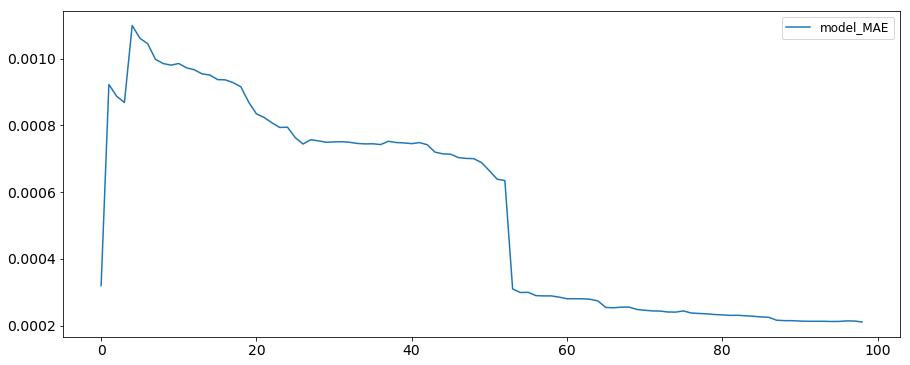

In [12]:
#plt.plot(a1, label = 'train_MAE')
plt.plot(b1, label = 'model_MAE')
#plt.plot([np.mean(predict[1] / predict[0]) for _ in range(len(bo.error_list)-1)], color = 'red', label = 'test_MAE')
plt.legend()
plt.show()

In [13]:
vals = bo.get_evaluations()
X = vals[0]
y = [k[0] for k in vals[1]]

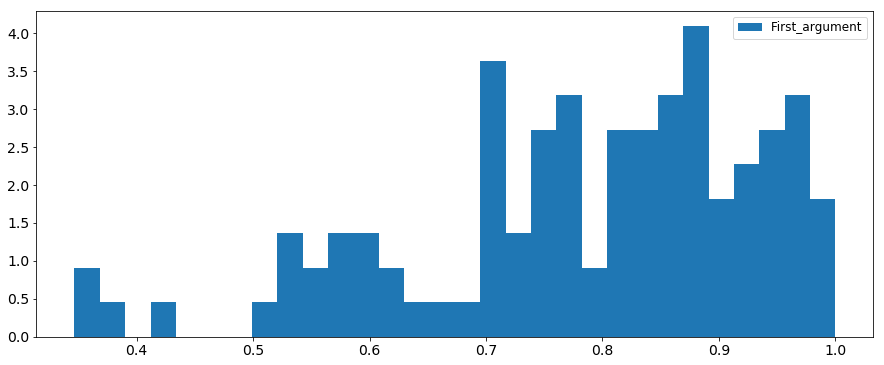

In [14]:
plt.hist(X.T[0], bins = 30, label = "First_argument", normed = True)
plt.legend()
plt.show()

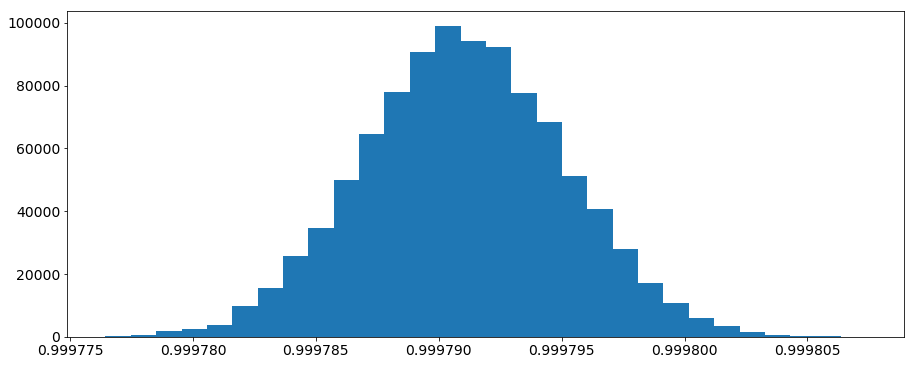

In [15]:
plt.hist(np.transpose(X_test)[0], bins = 30, normed = True)
plt.show()

----------
### Lets look at the histogram of the avaliable values relative to the theoretical distribution for the model covariance matrix

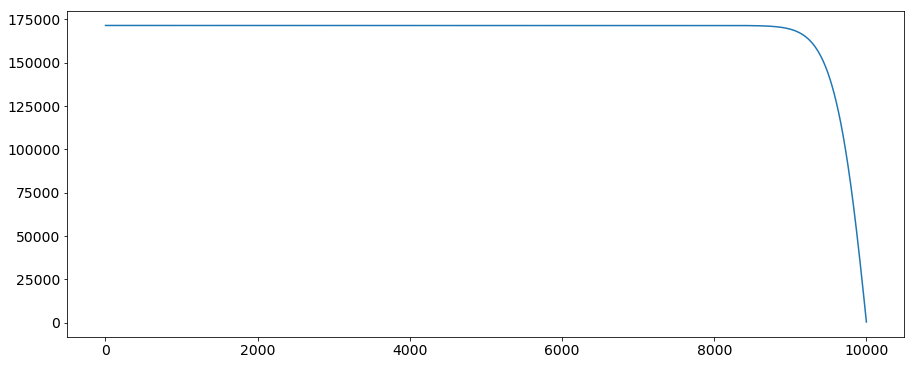

In [16]:
plt.plot(np.array(bo.sigma_arr)[0])
plt.show()

In [49]:
rho_arr = ss.norm.pdf(x = np.arange(0,1,0.0001), loc = hmdw.get_func().mean[0], scale = np.sqrt(cov[0][0]))
arr = np.array([np.arange(0,1,0.0001) for _ in range(10)])
mass = rho_foo_1(arr.T)

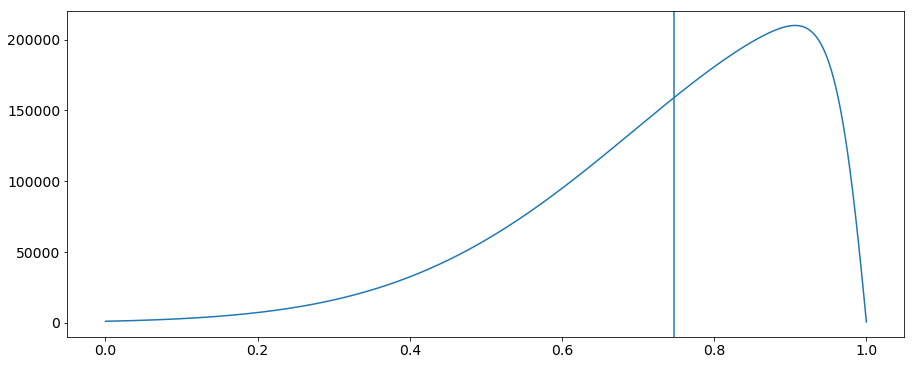

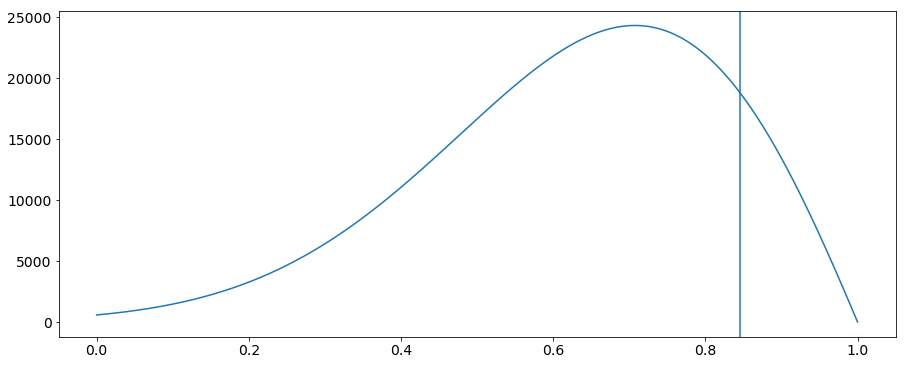

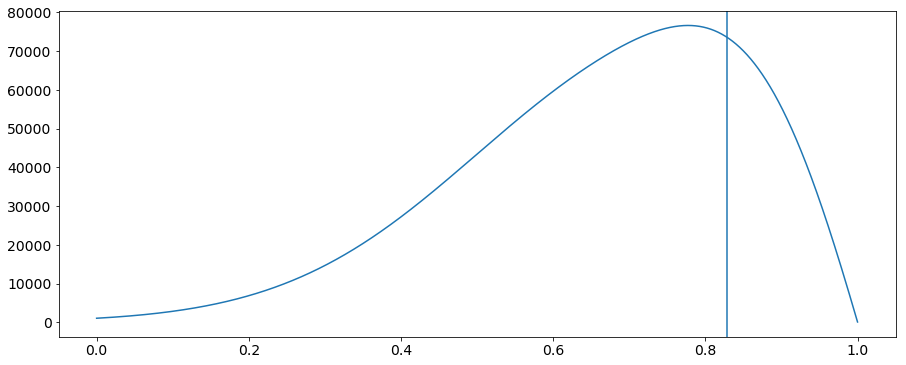

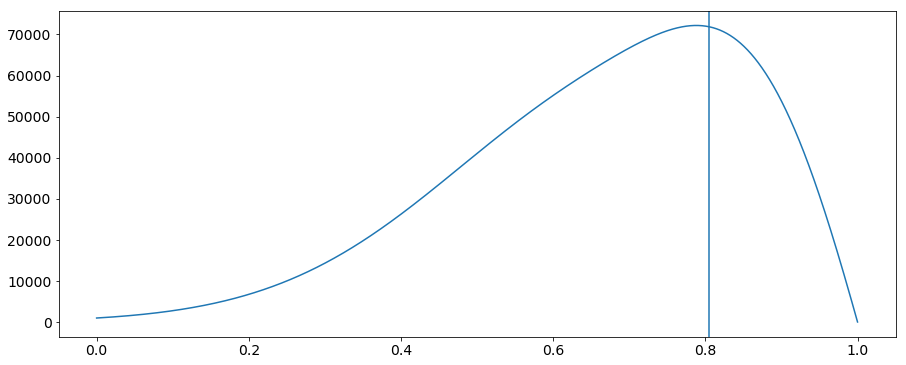

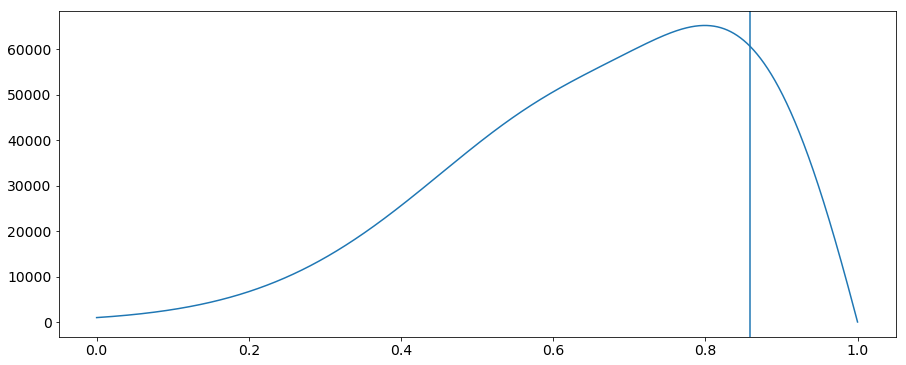

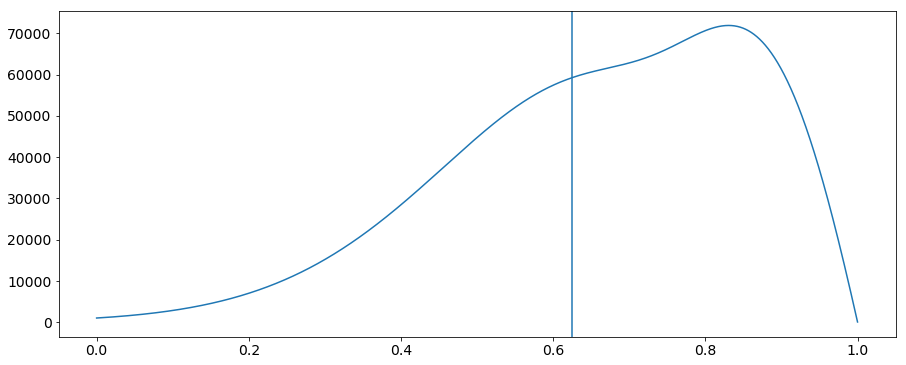

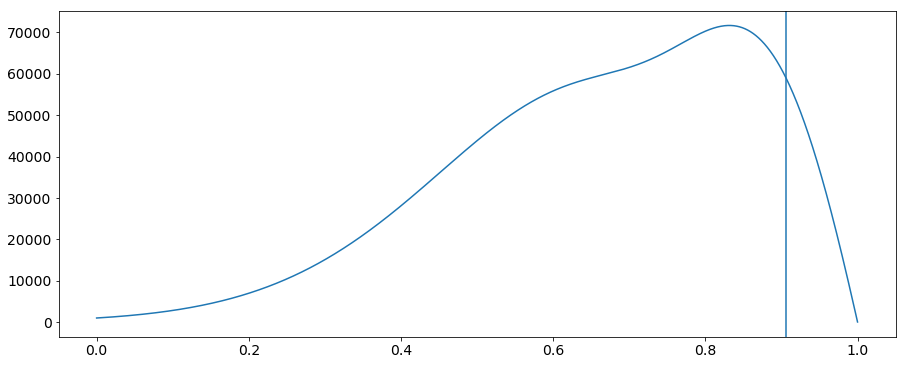

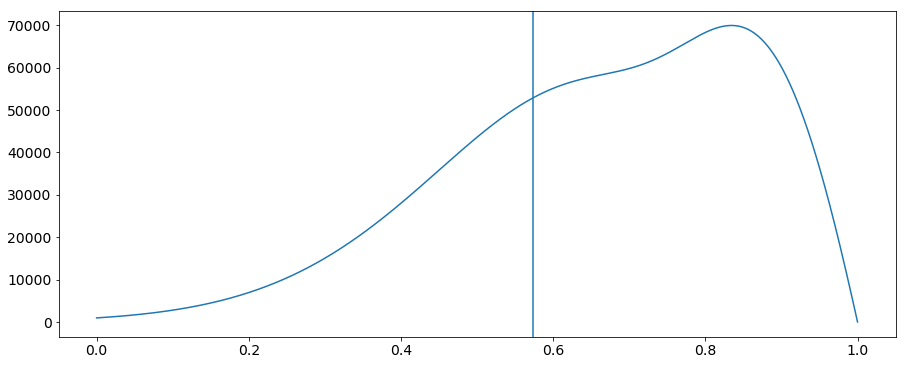

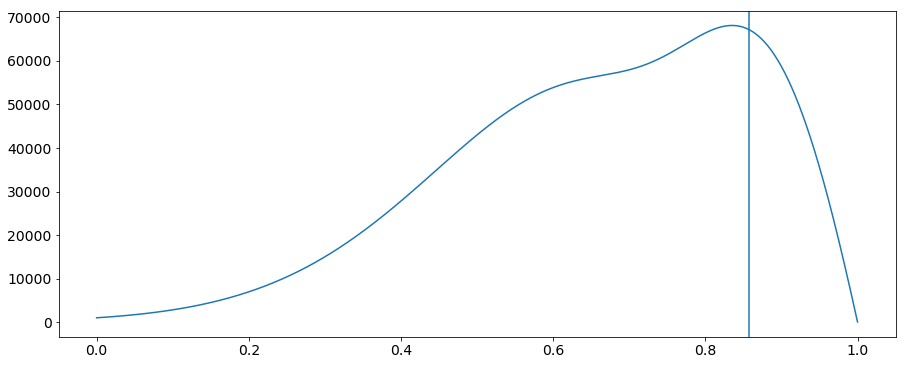

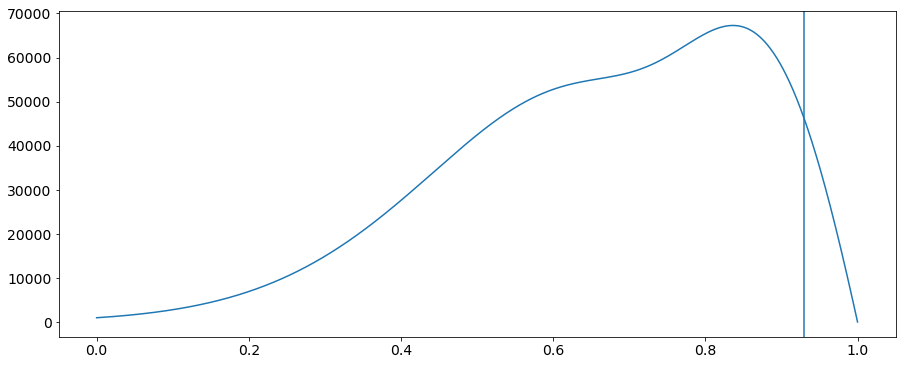

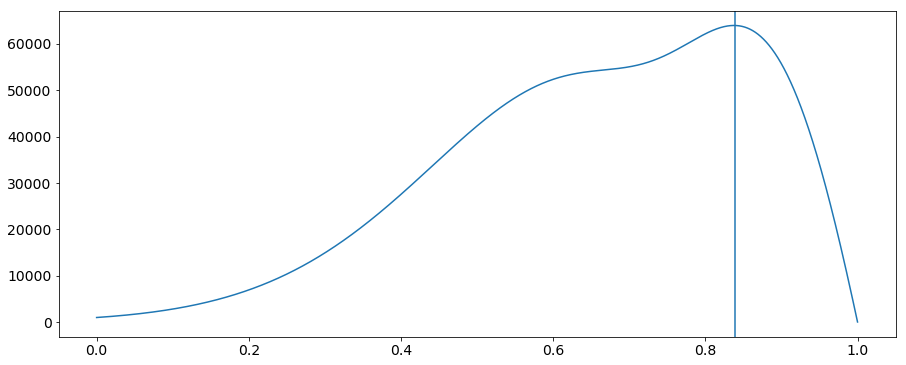

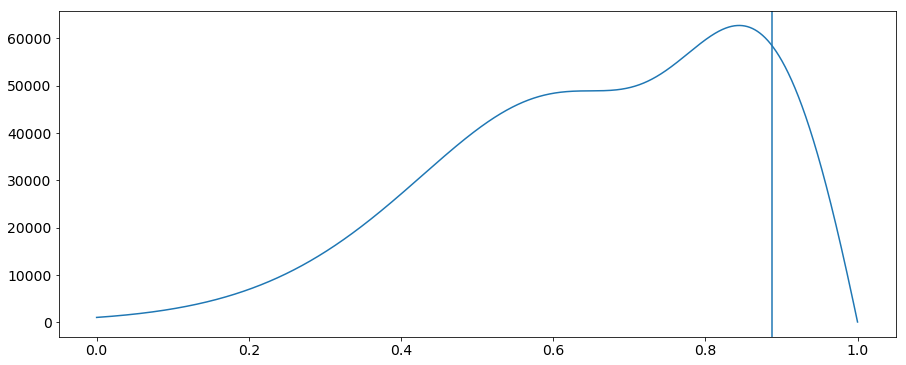

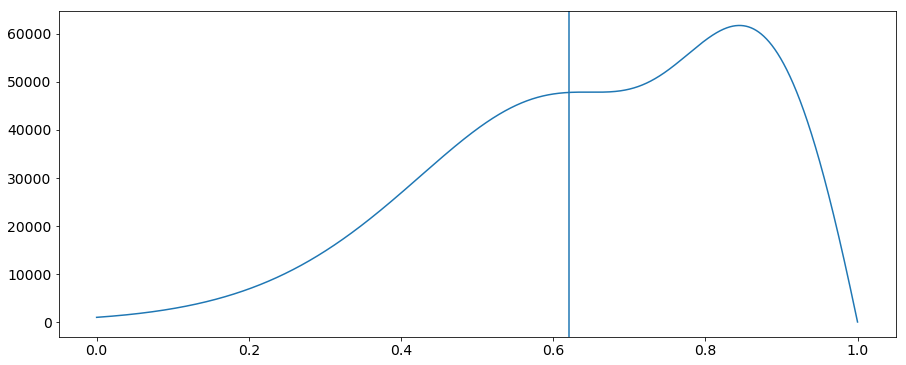

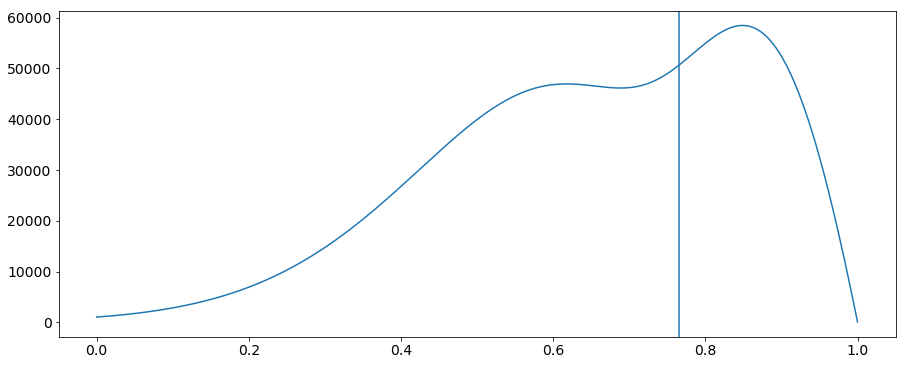

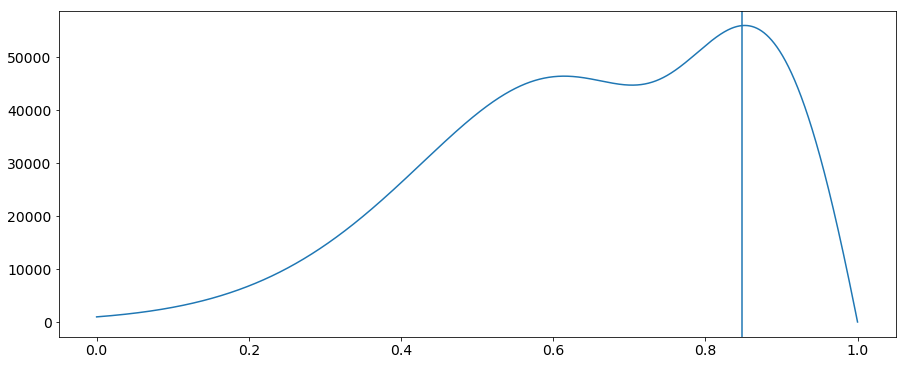

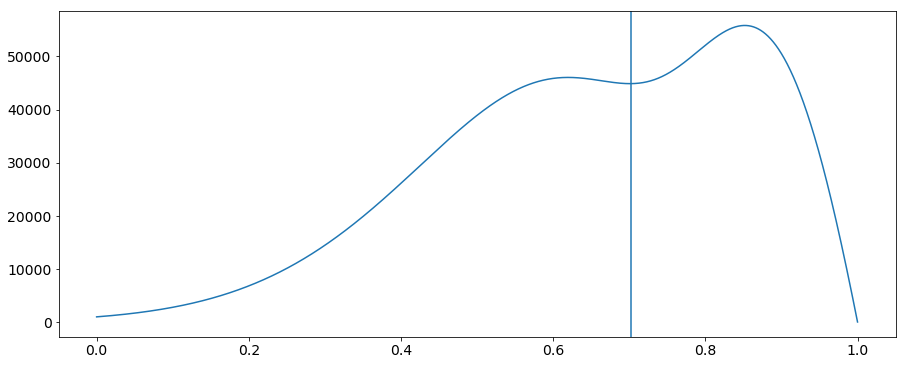

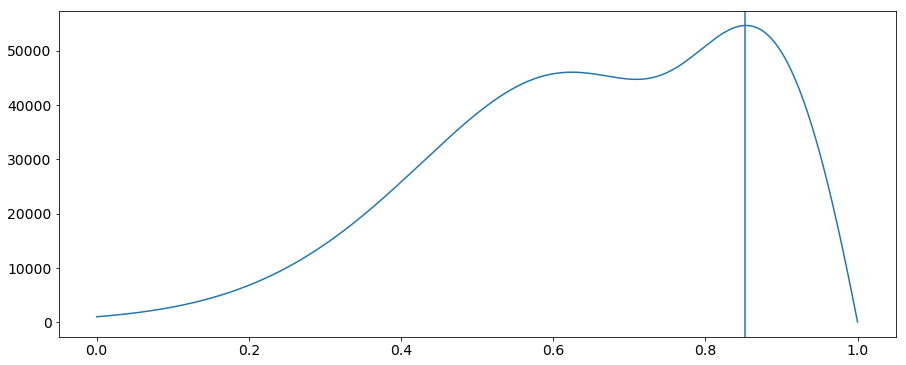

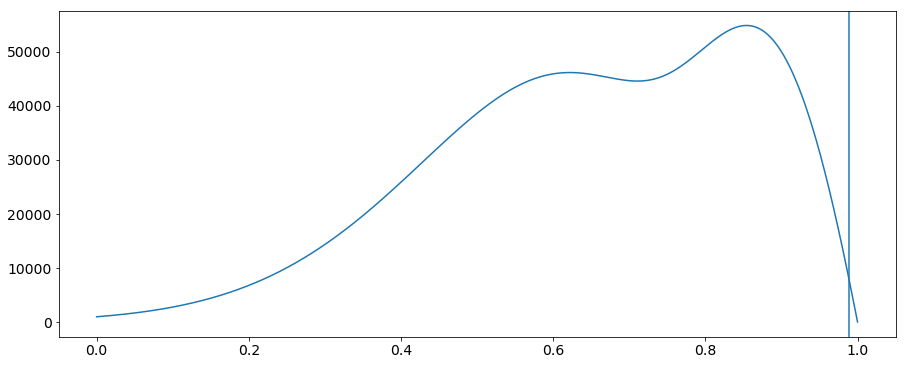

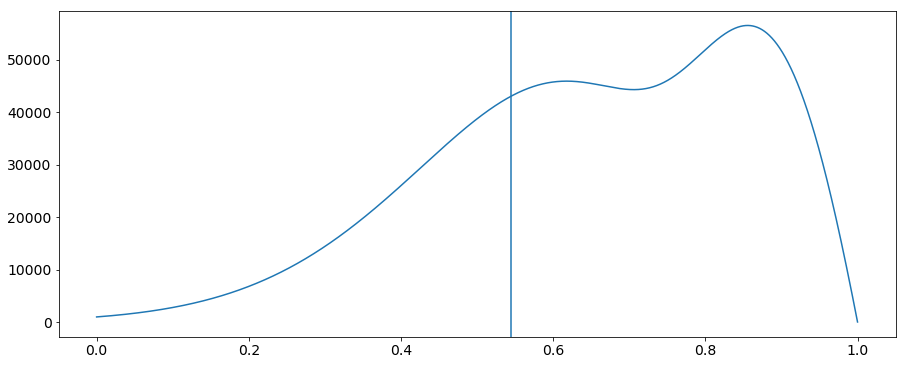

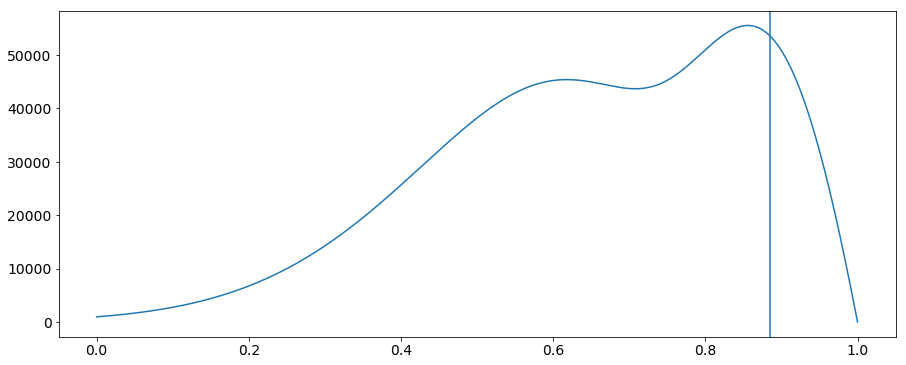

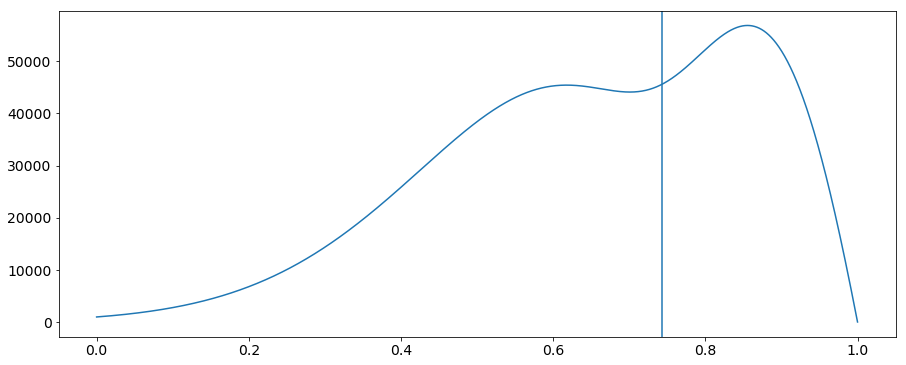

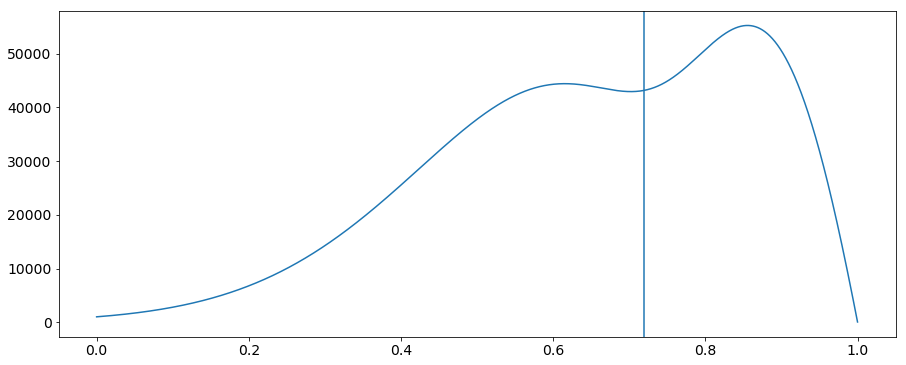

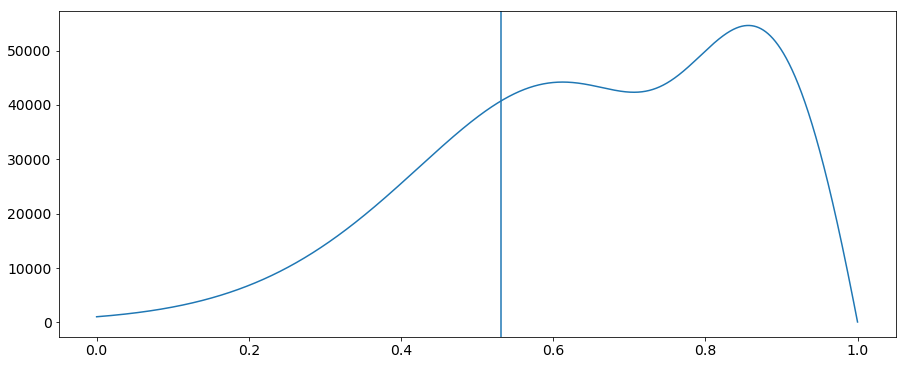

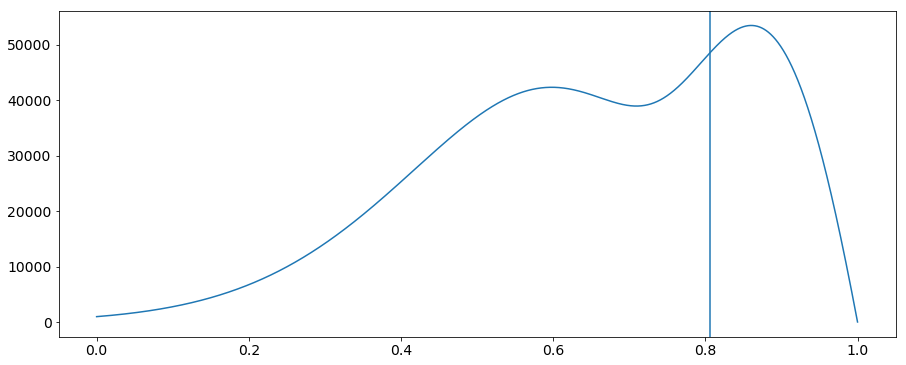

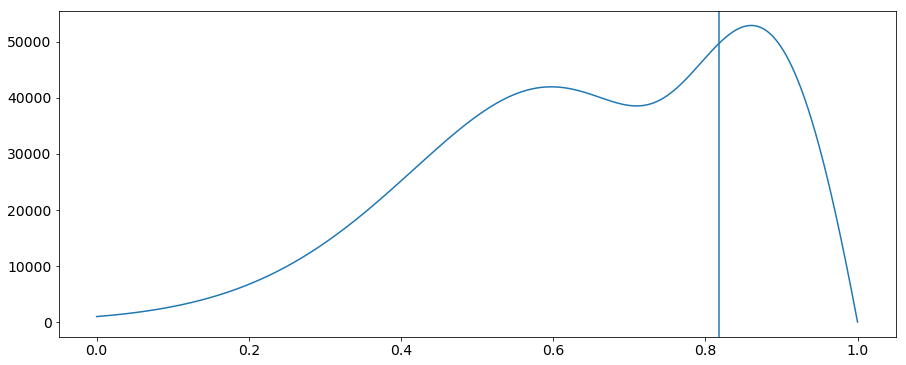

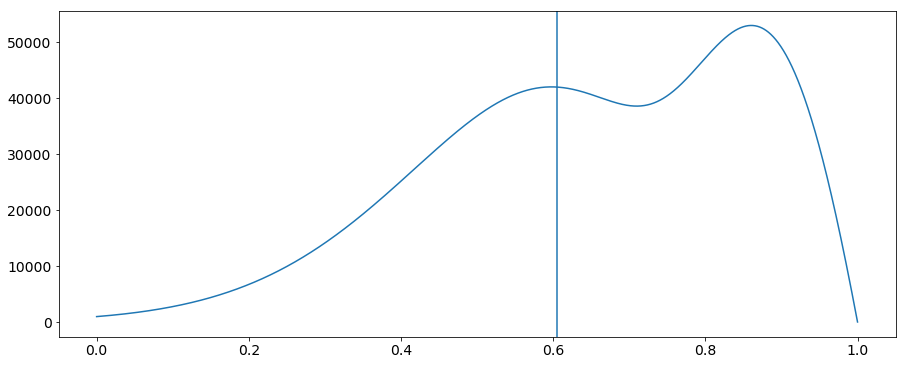

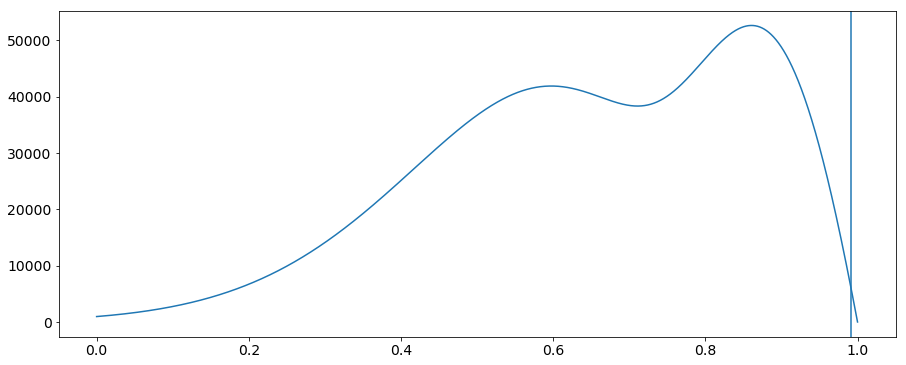

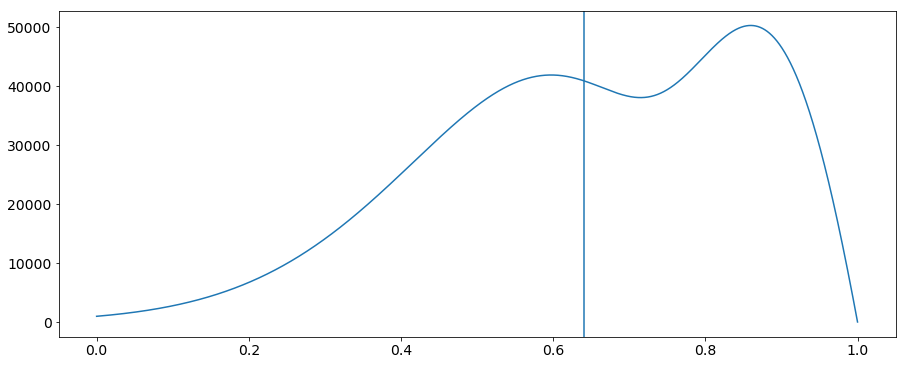

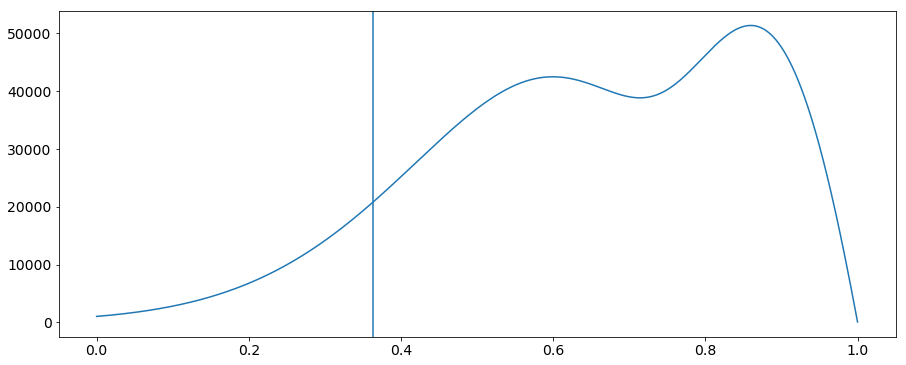

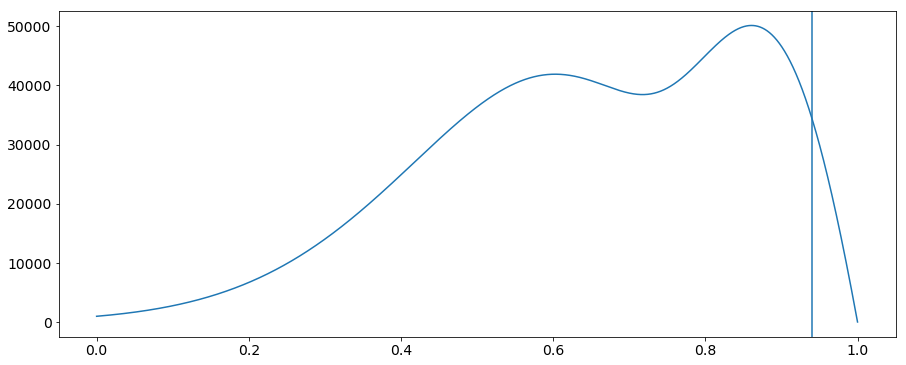

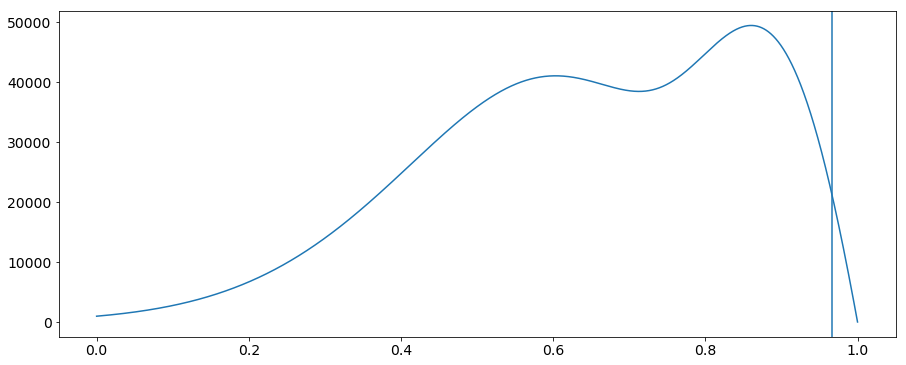

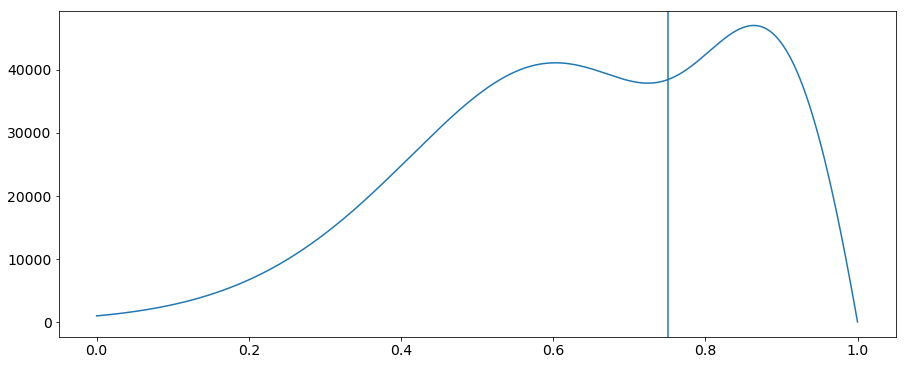

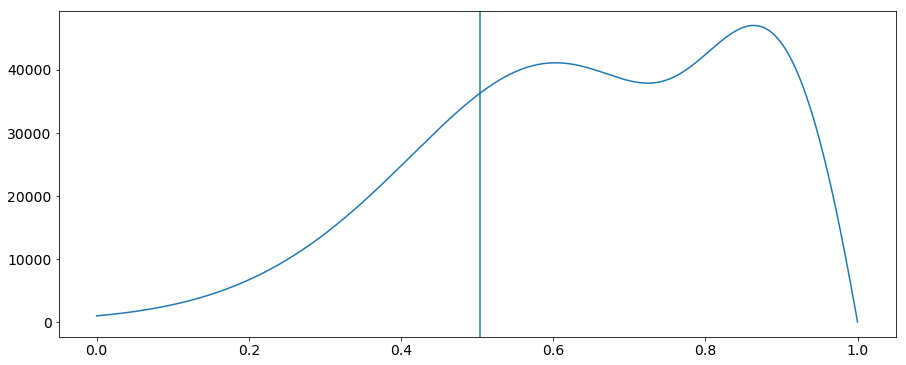

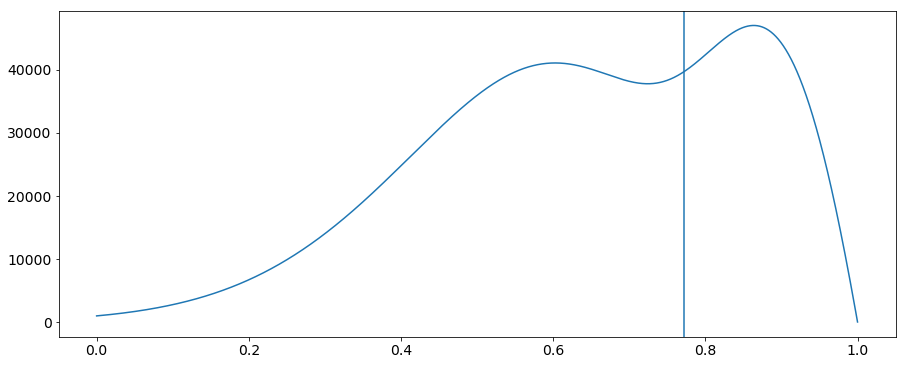

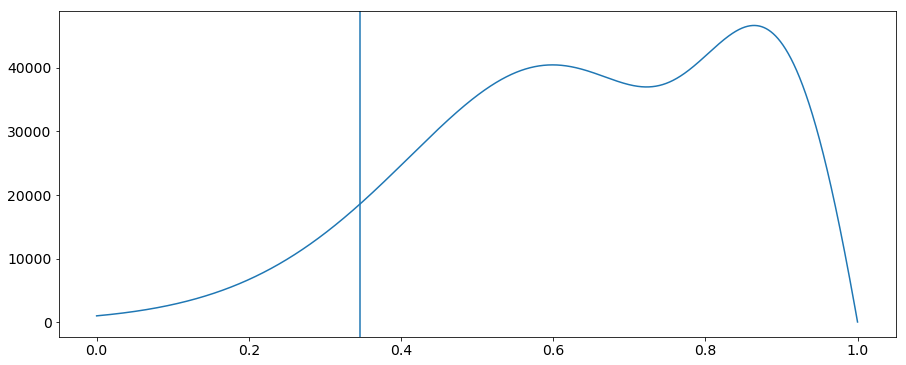

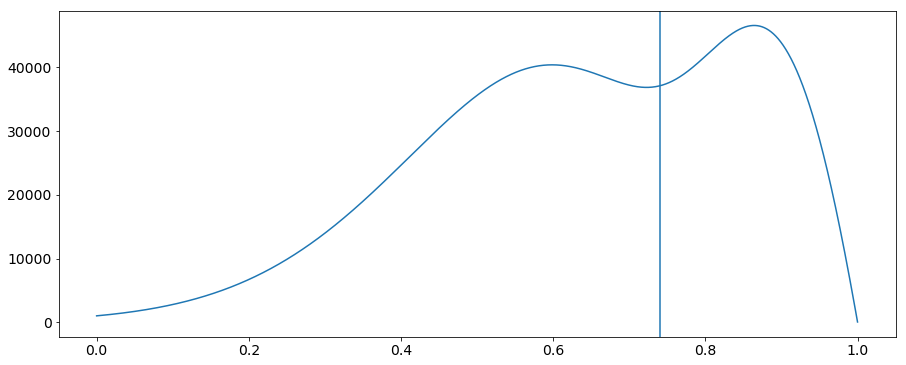

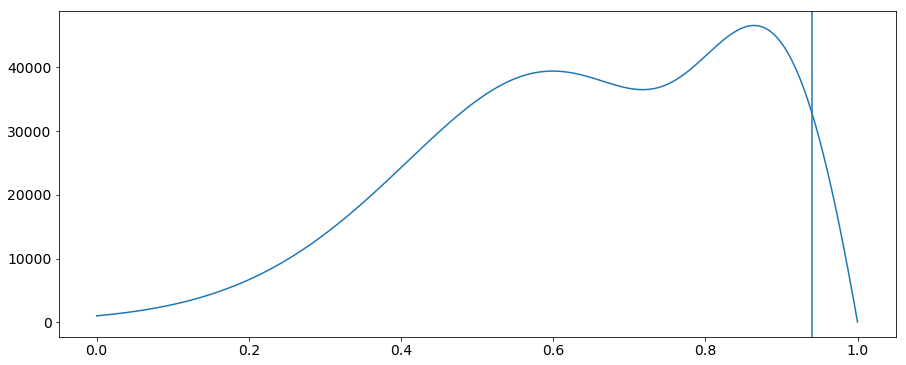

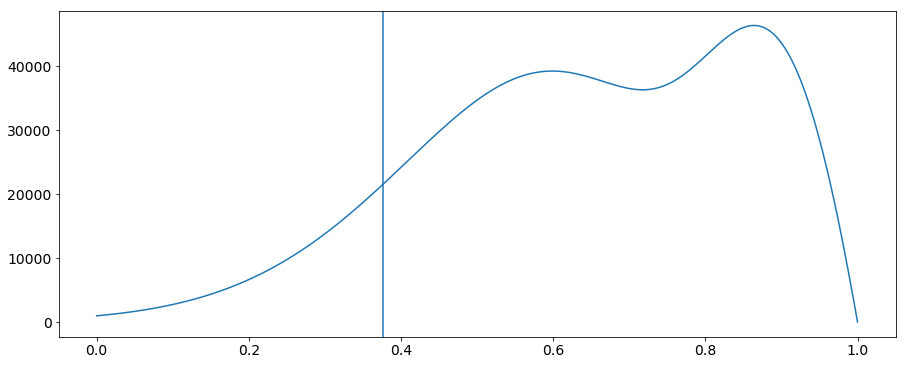

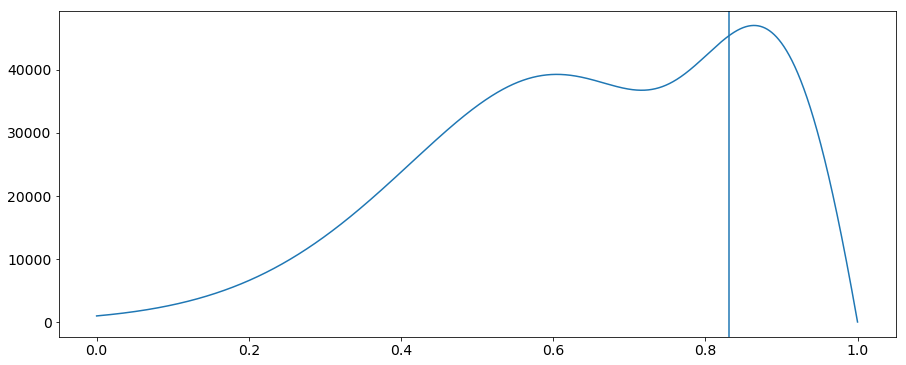

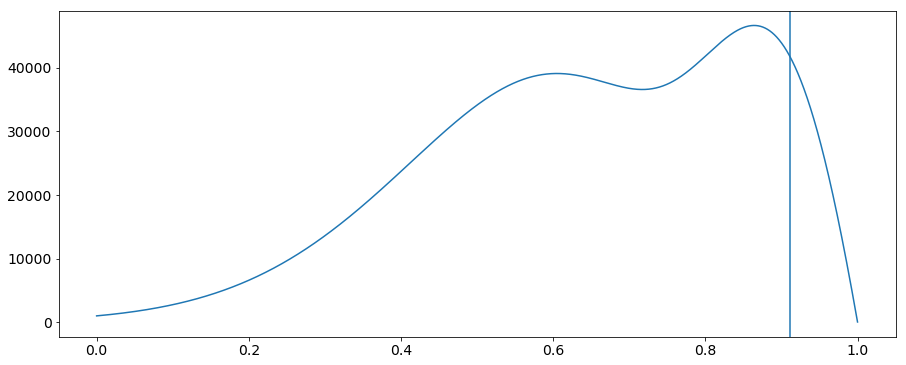

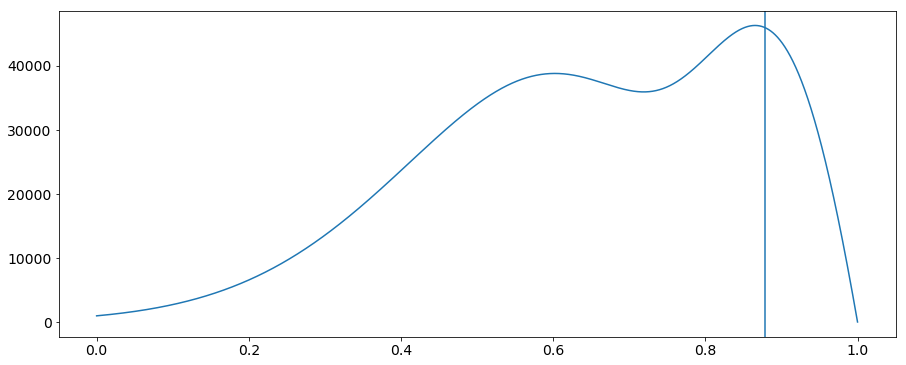

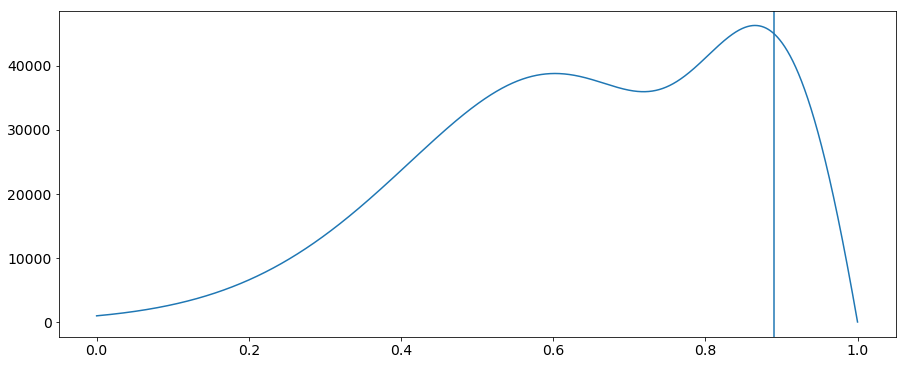

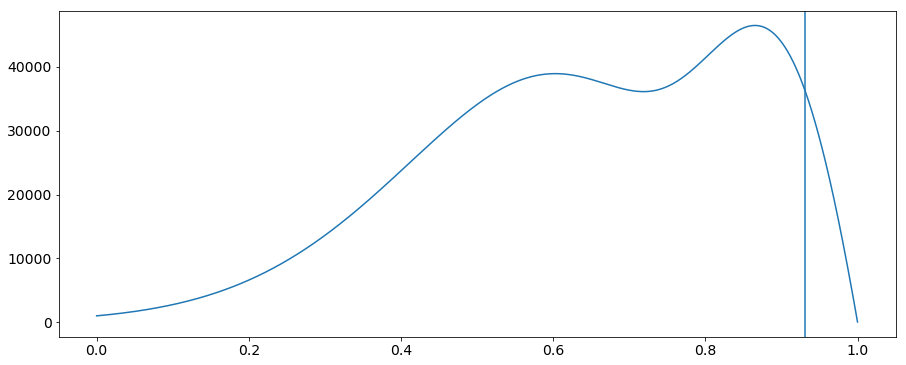

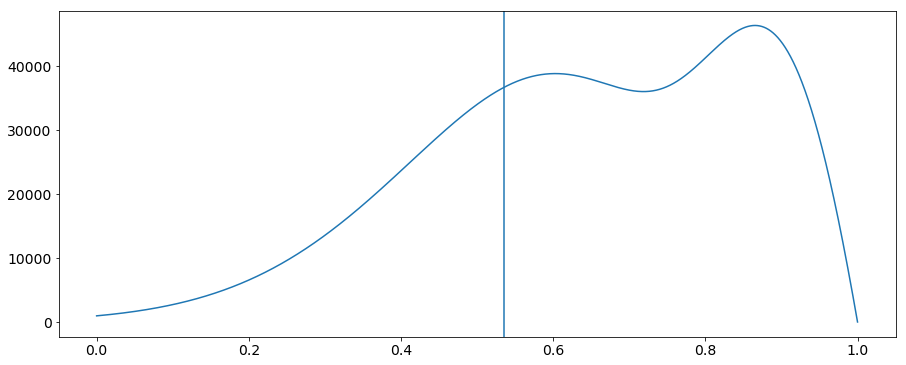

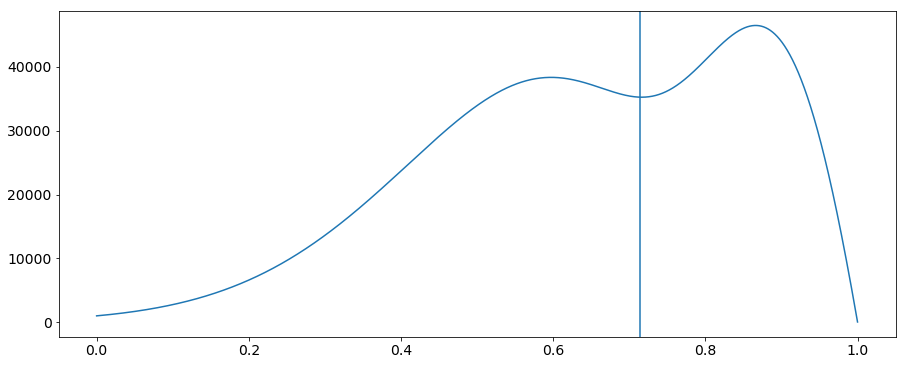

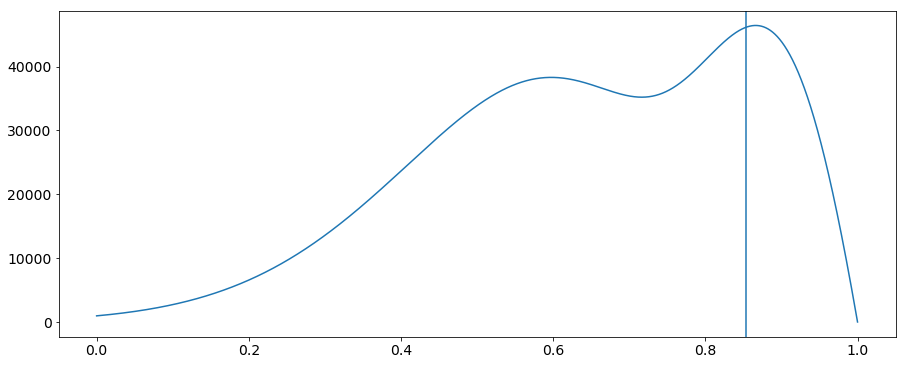

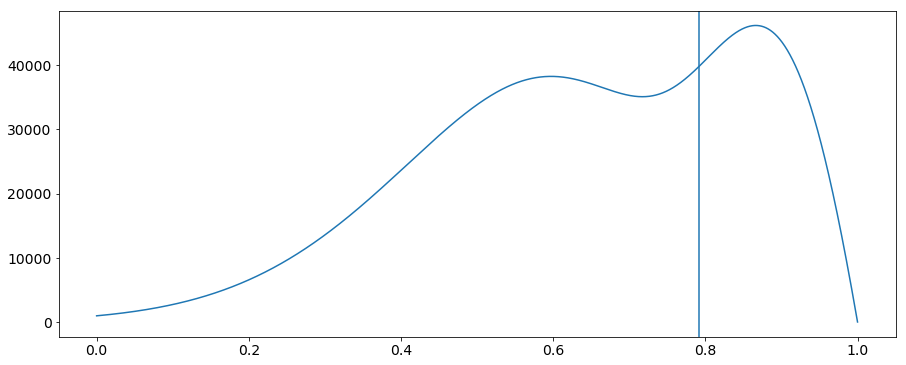

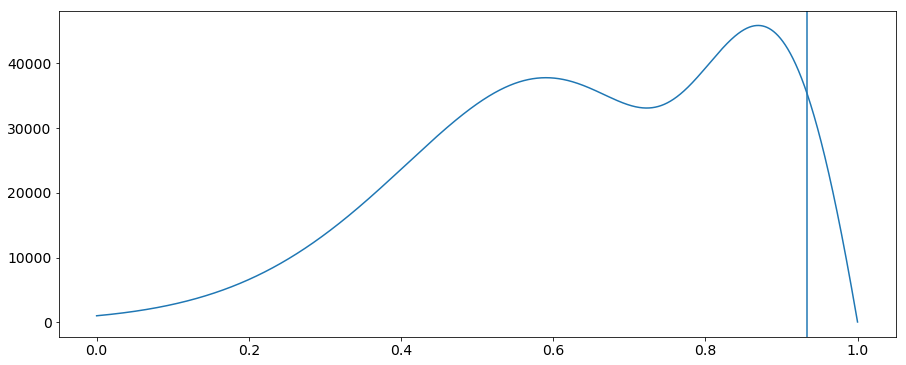

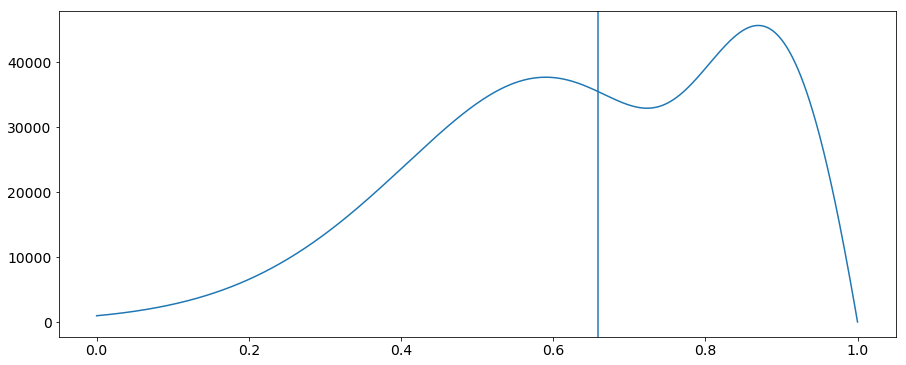

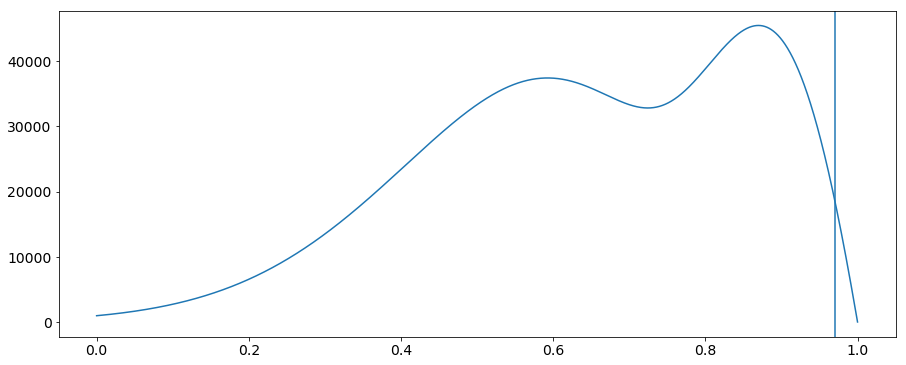

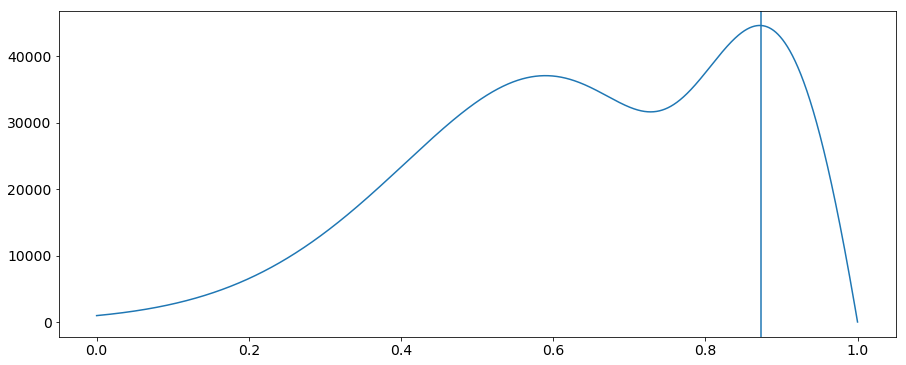

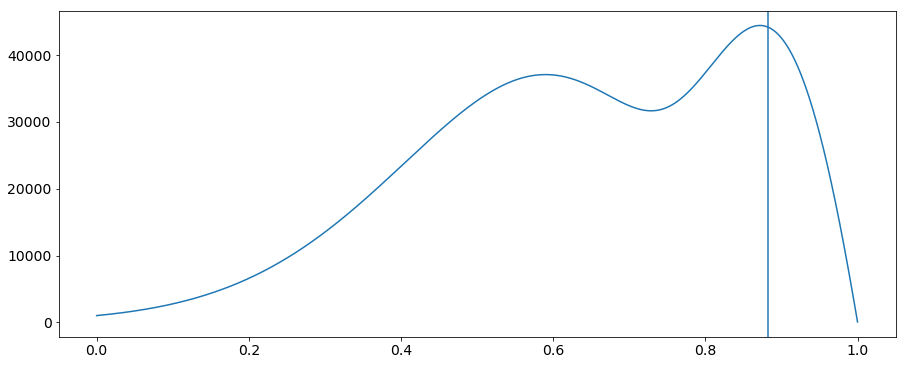

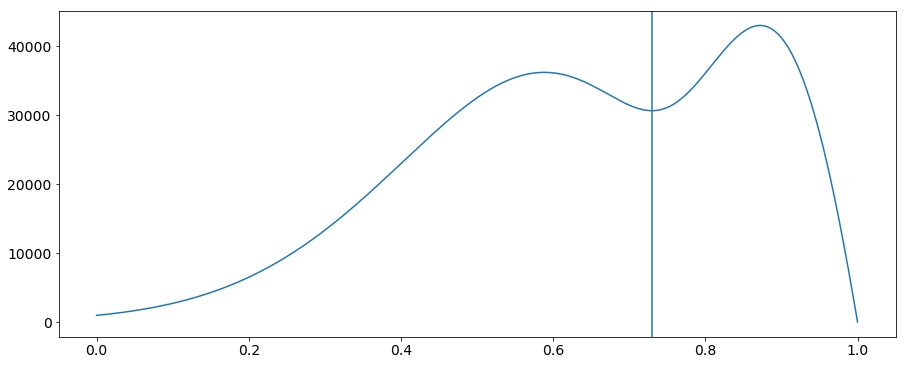

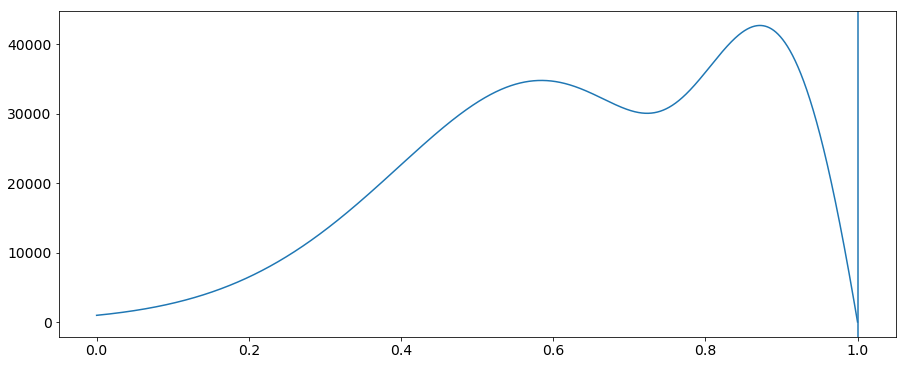

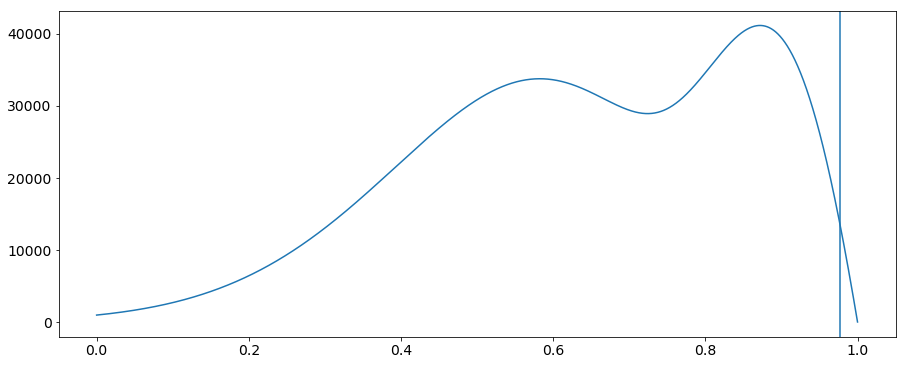

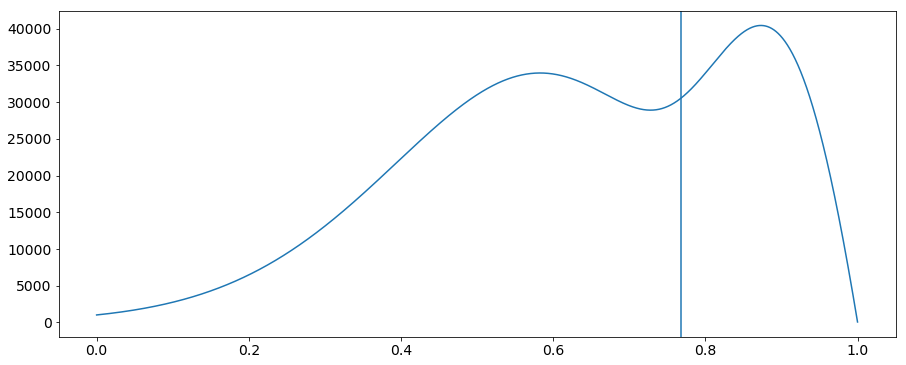

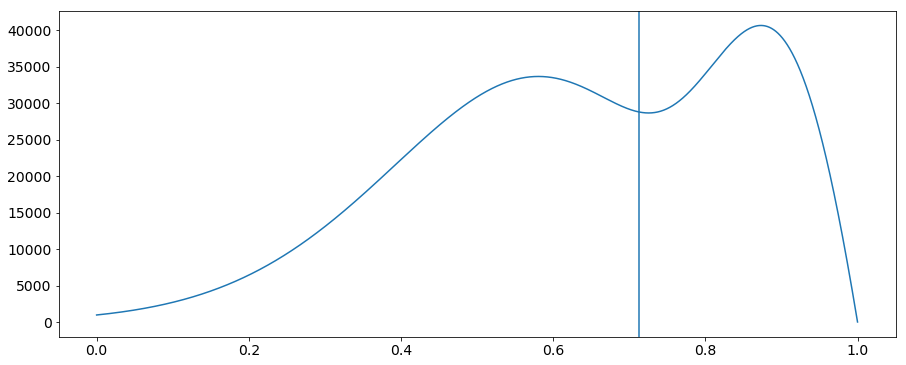

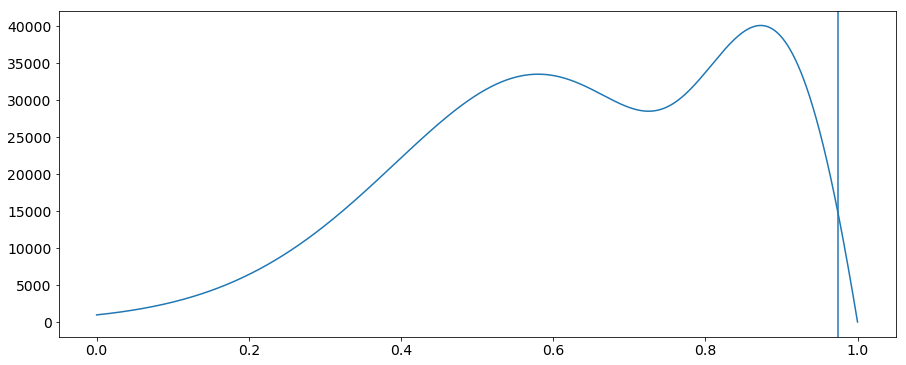

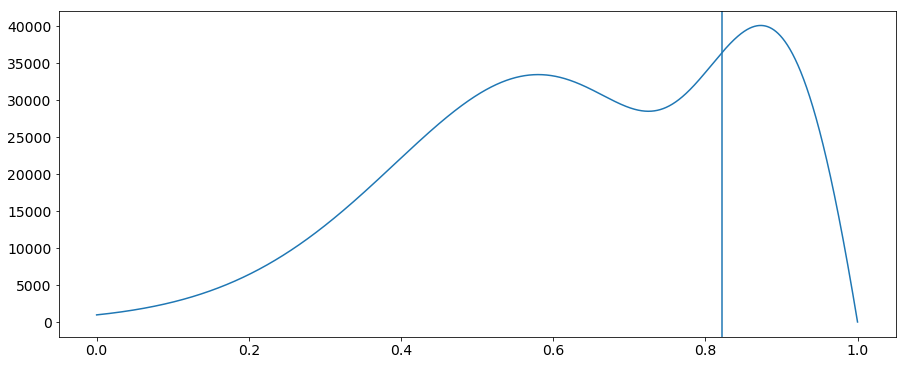

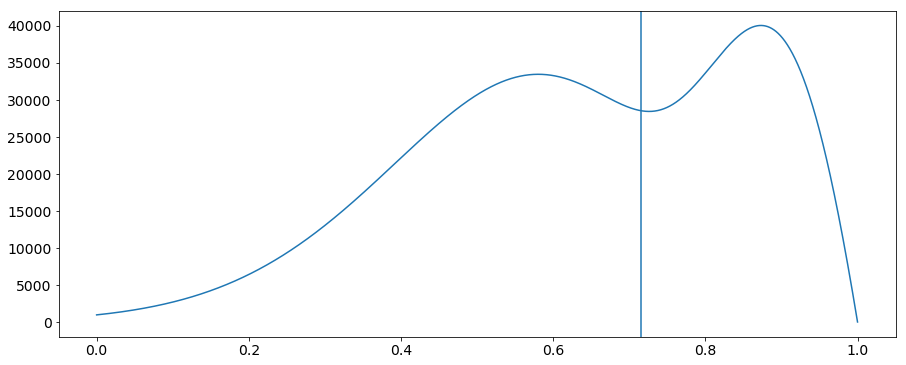

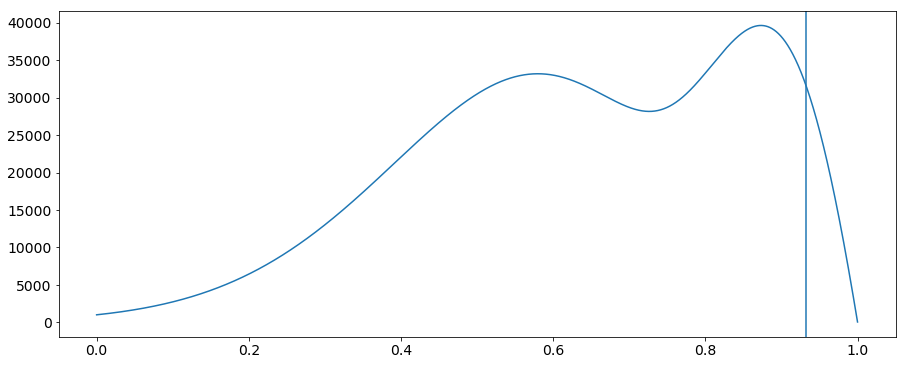

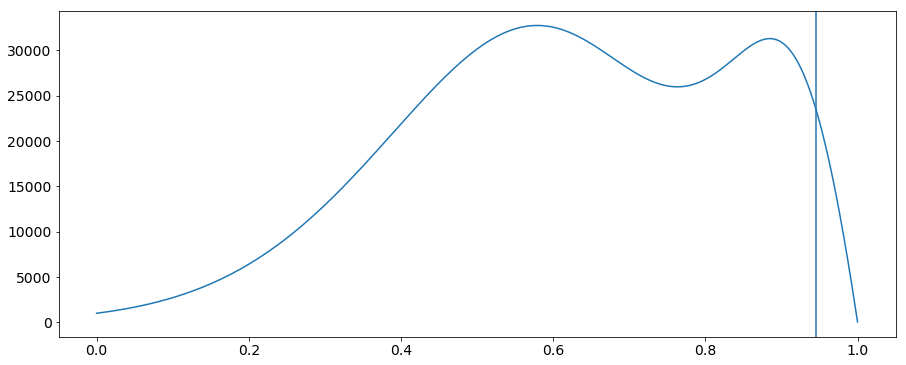

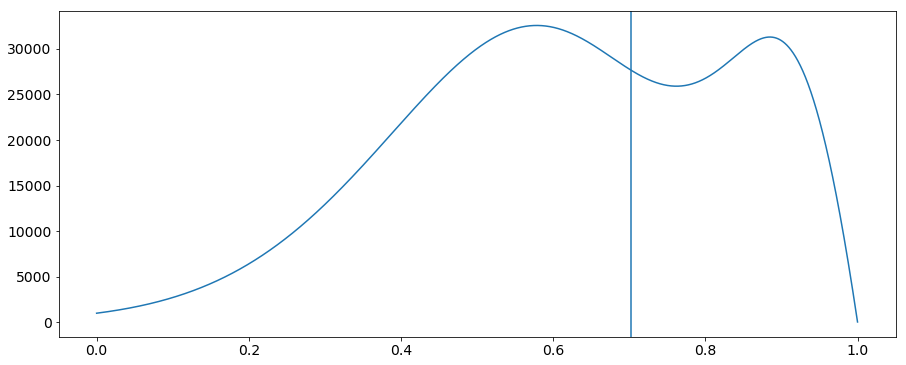

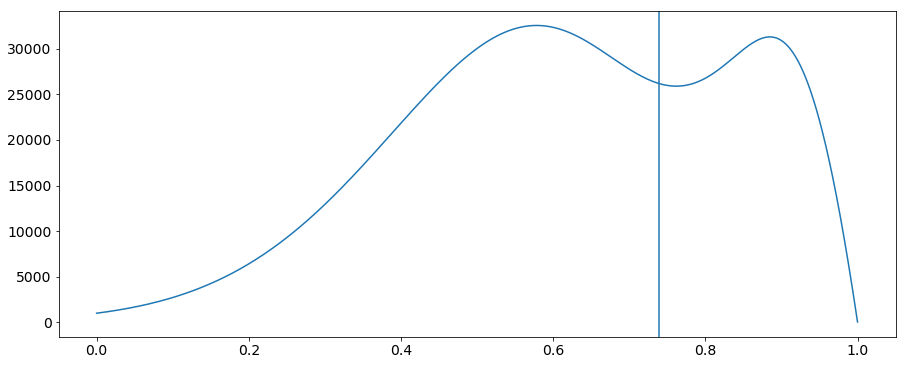

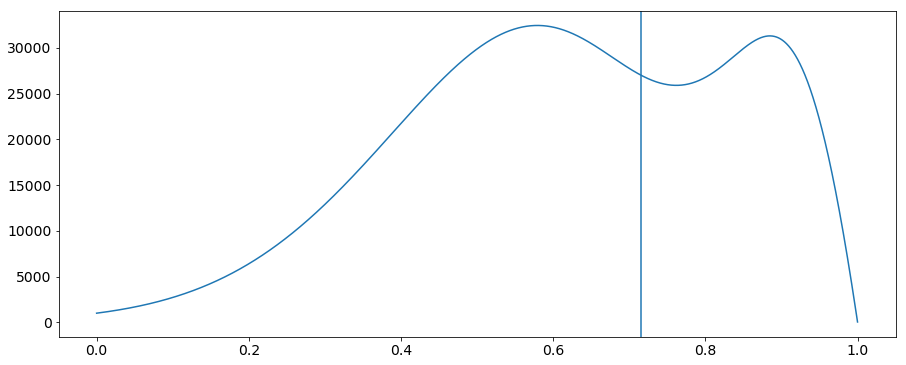

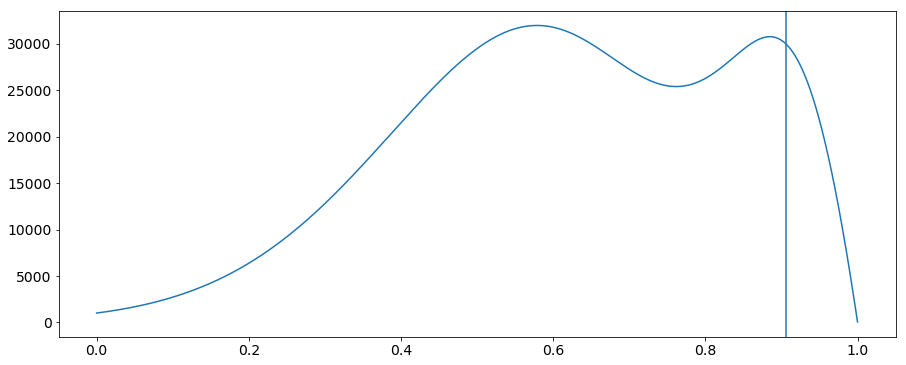

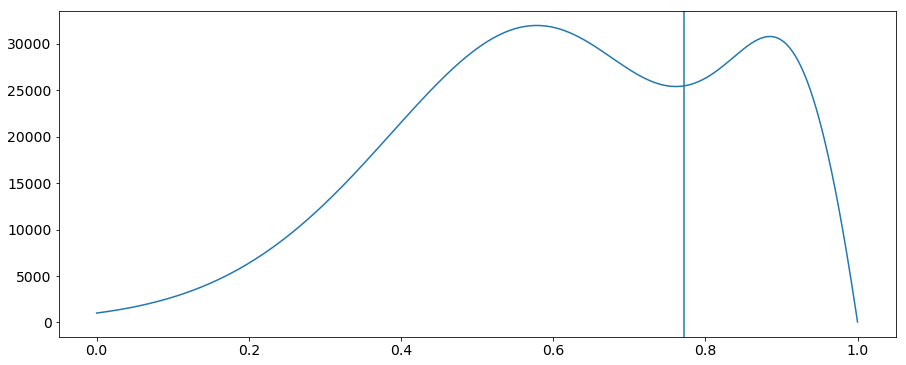

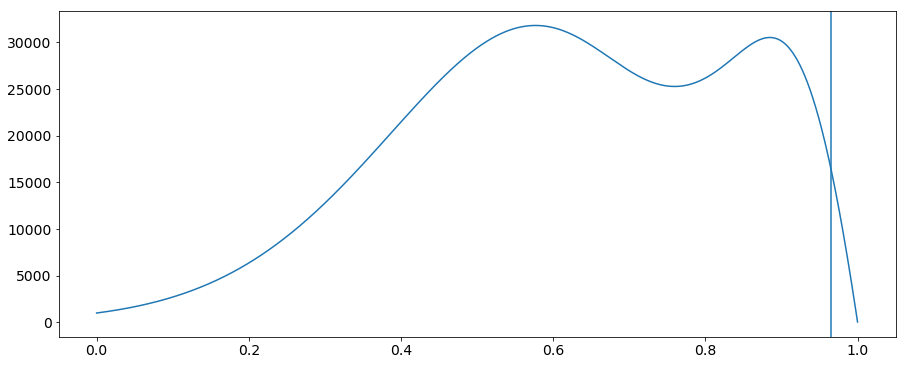

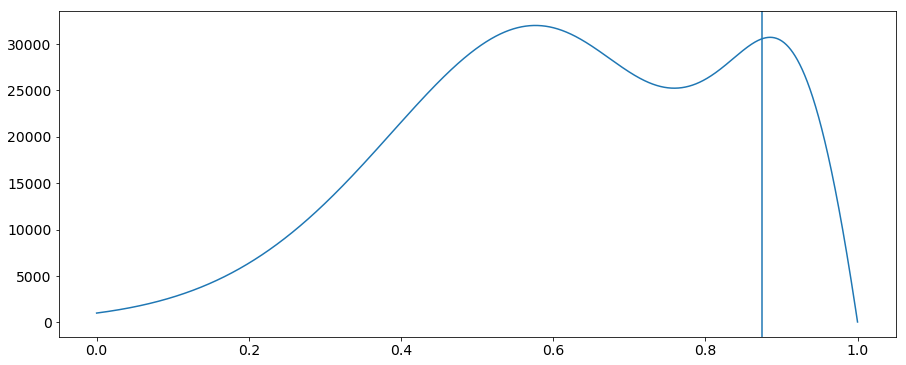

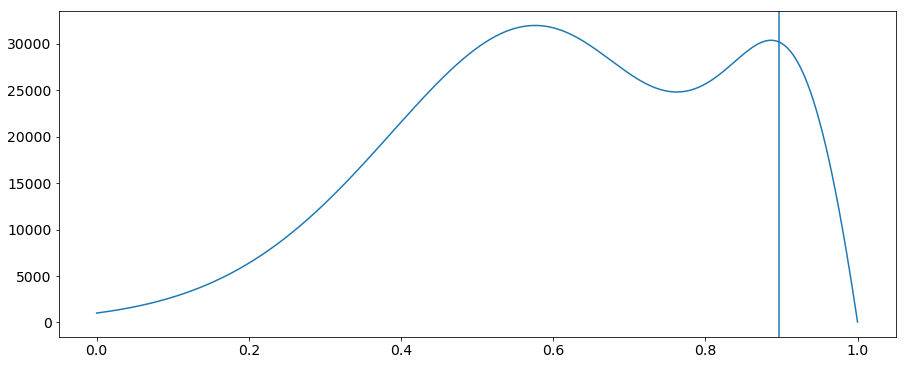

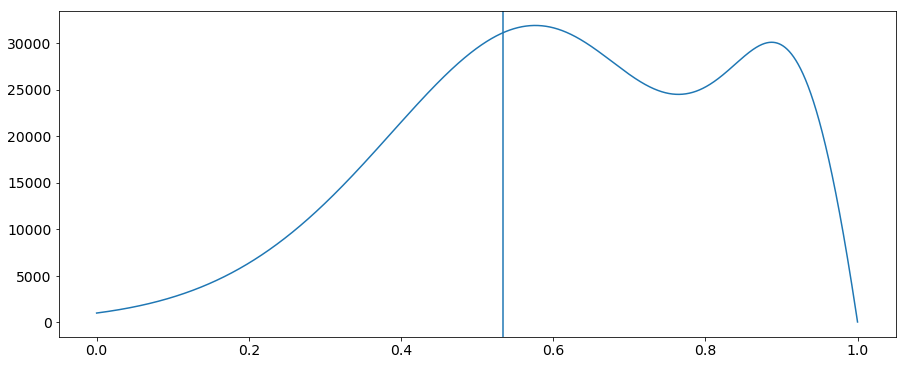

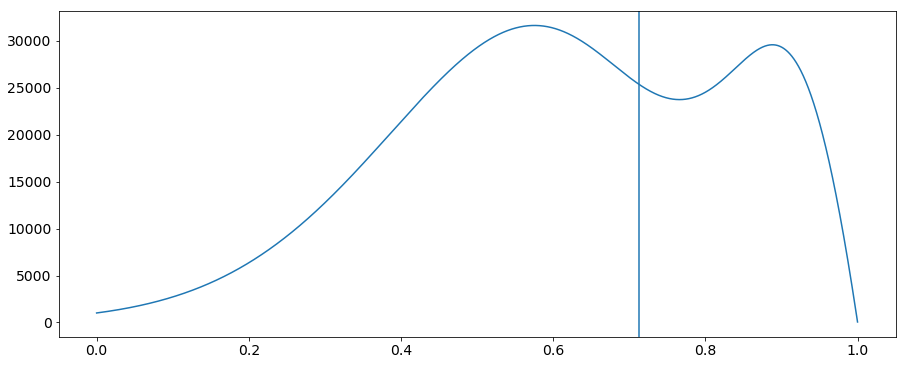

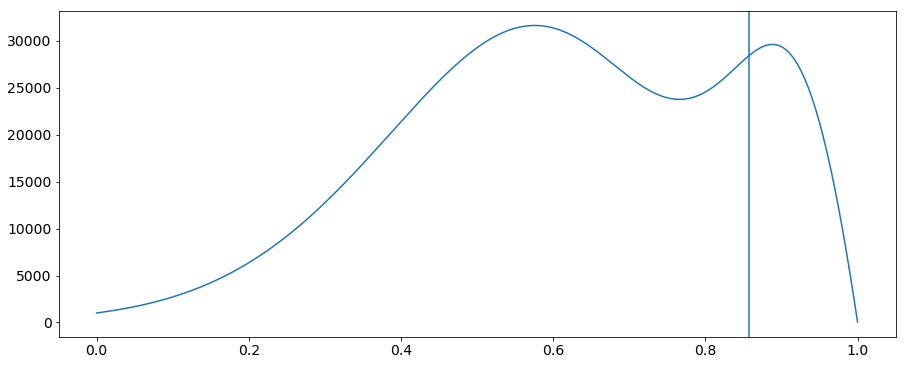

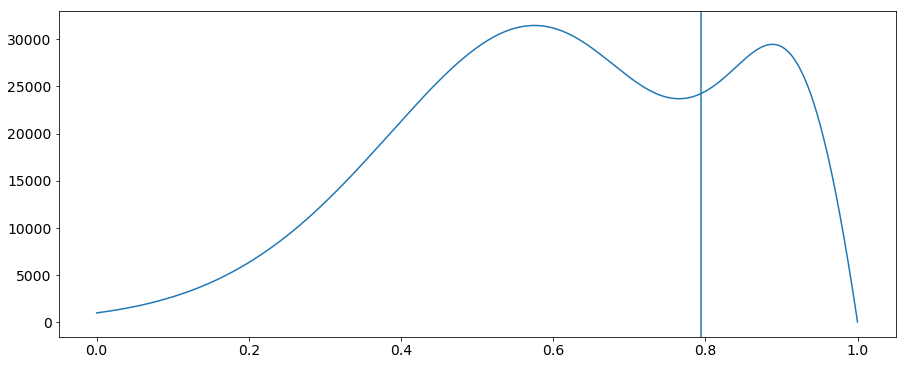

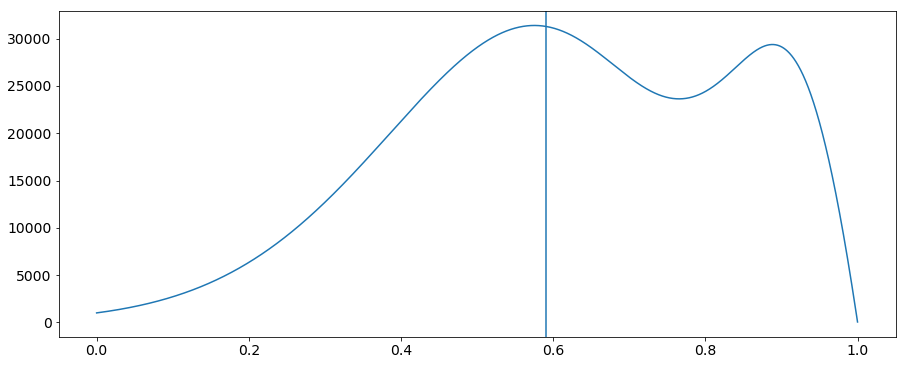

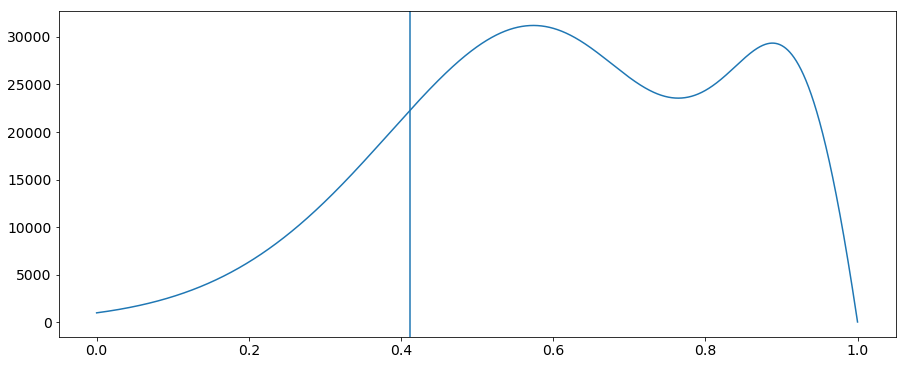

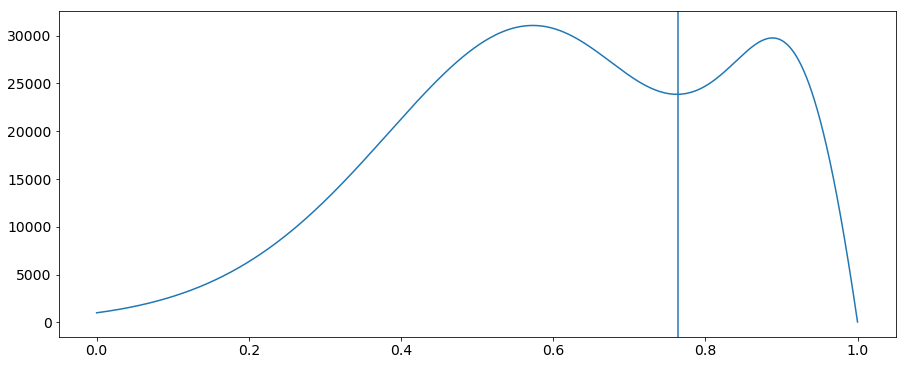

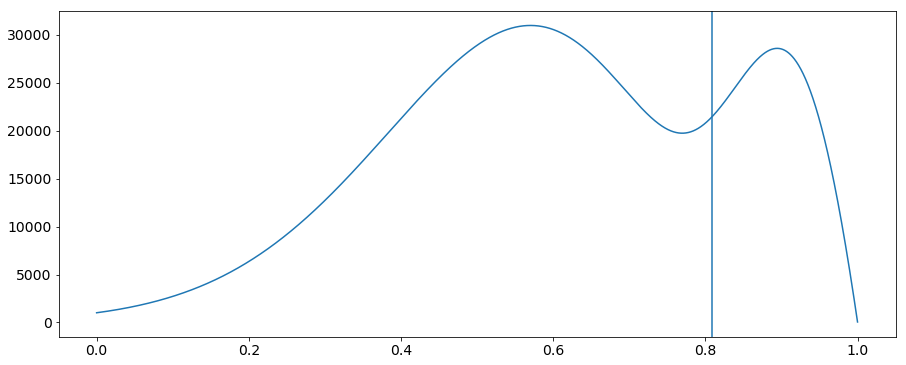

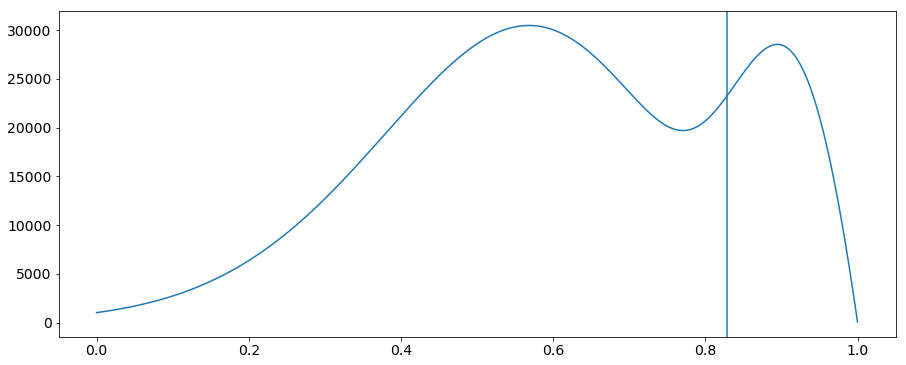

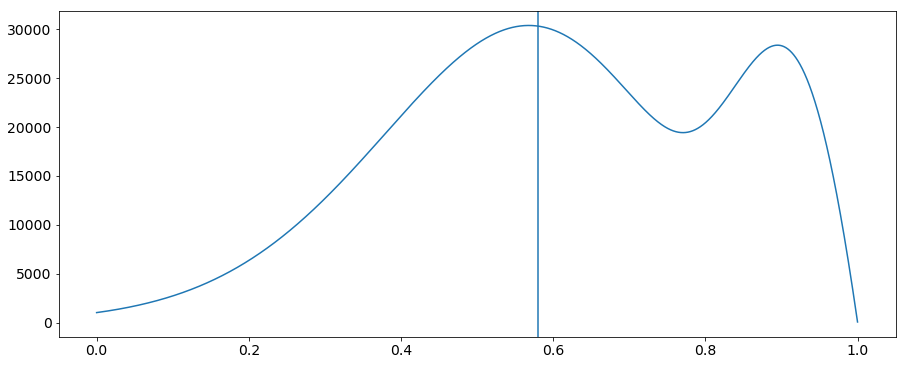

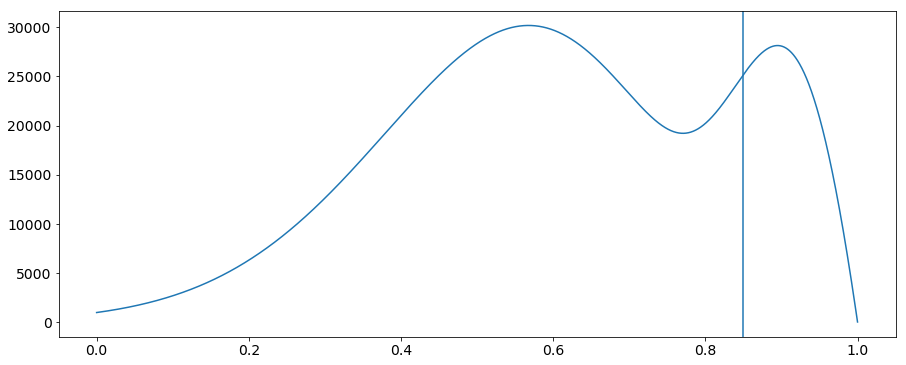

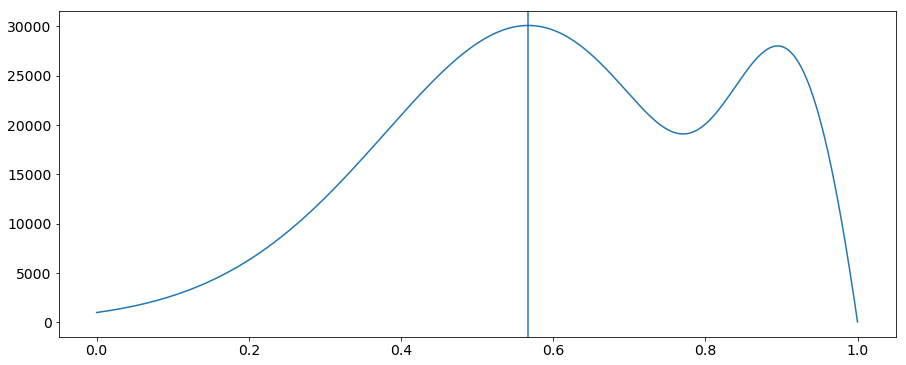

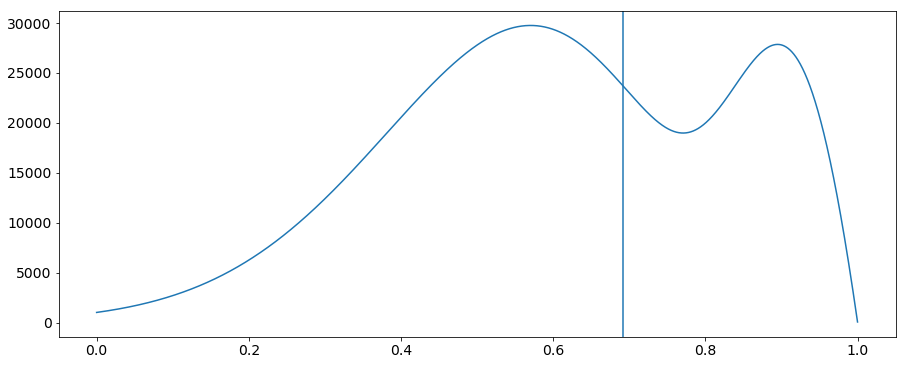

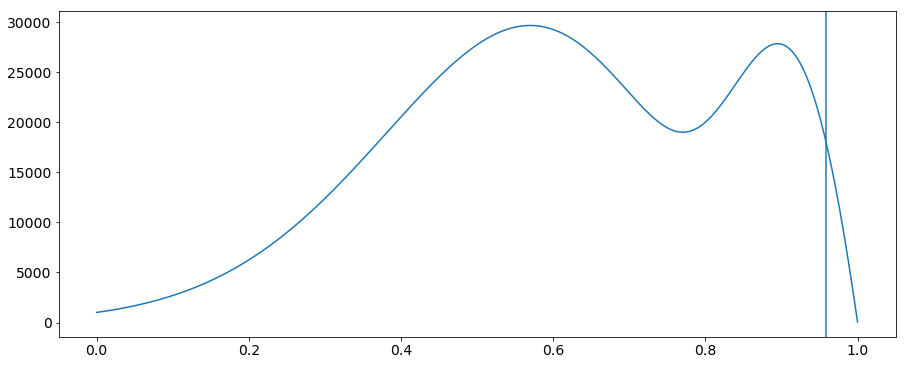

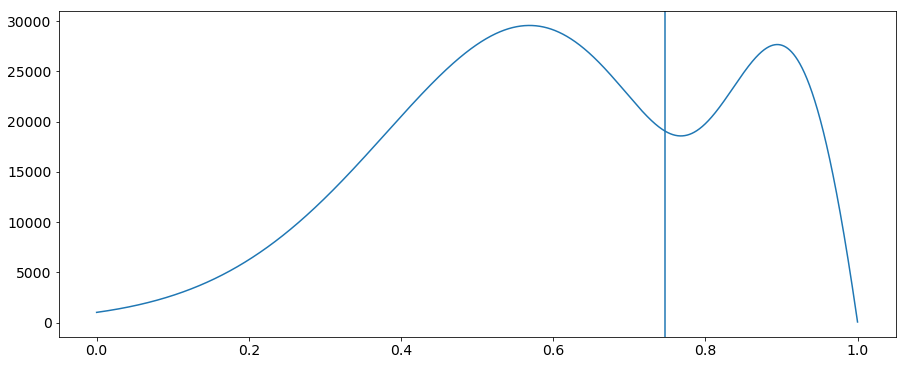

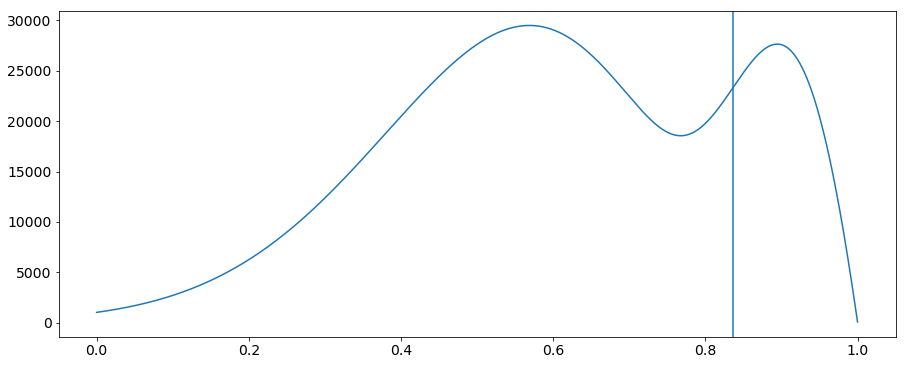

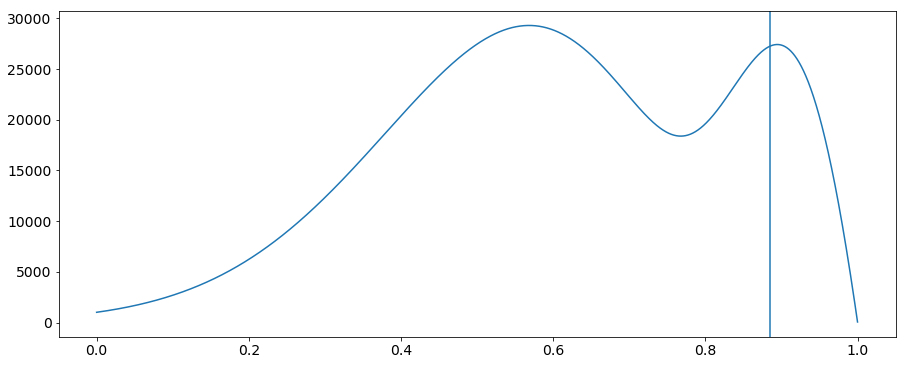

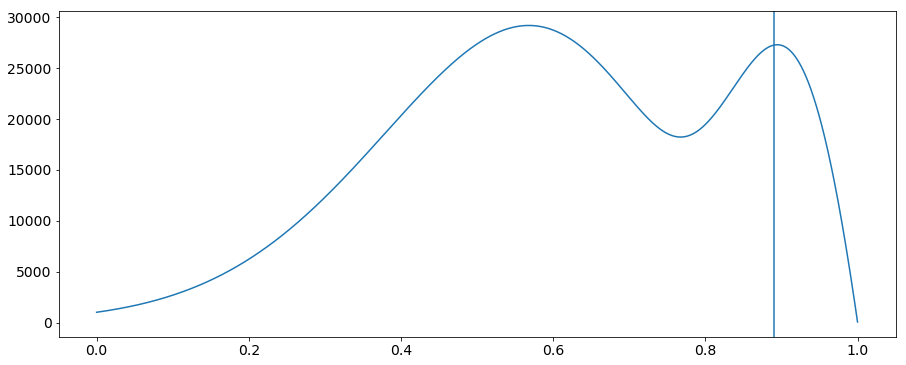

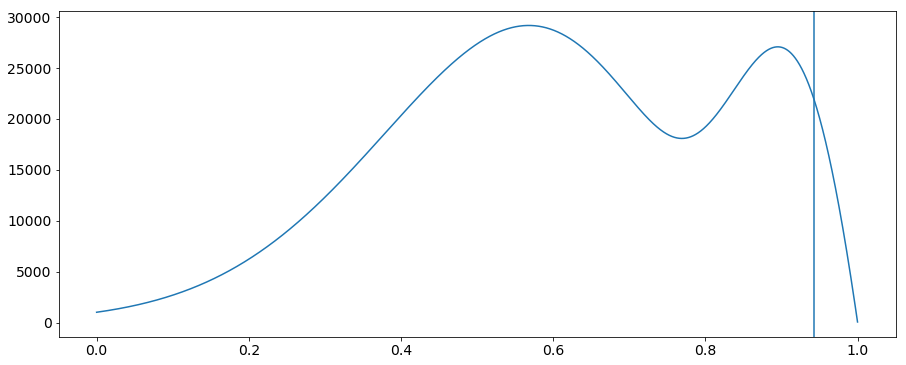

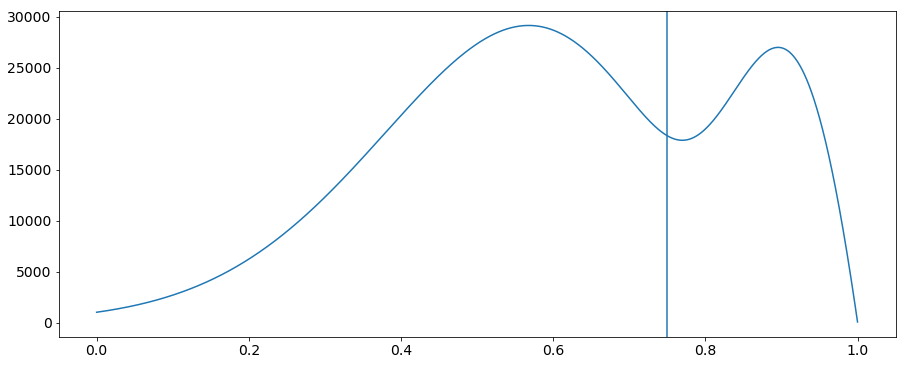

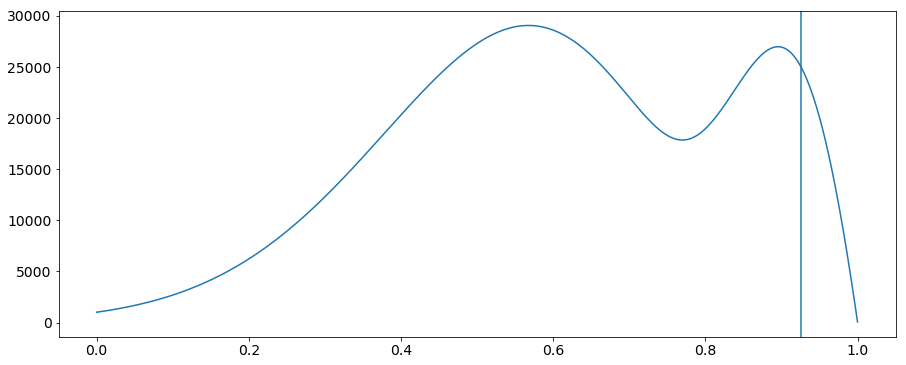

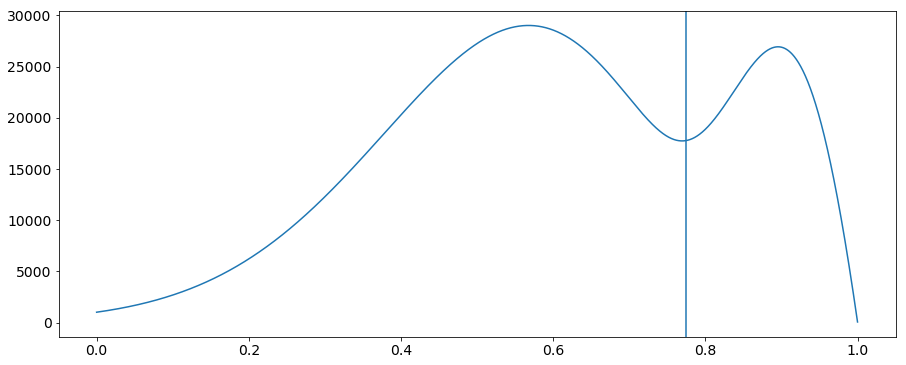

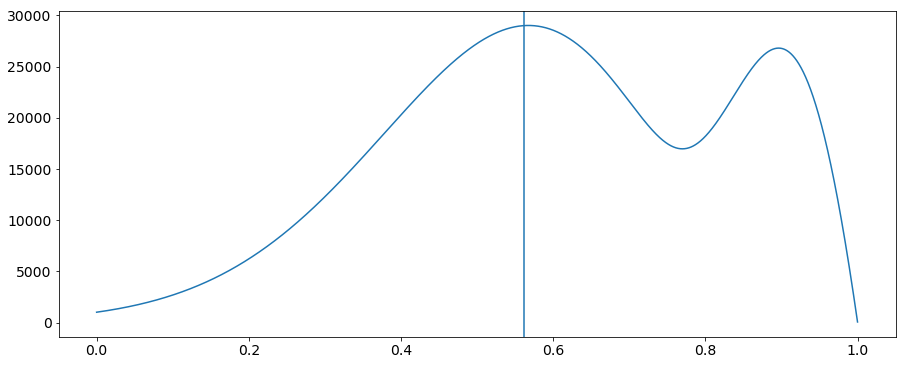

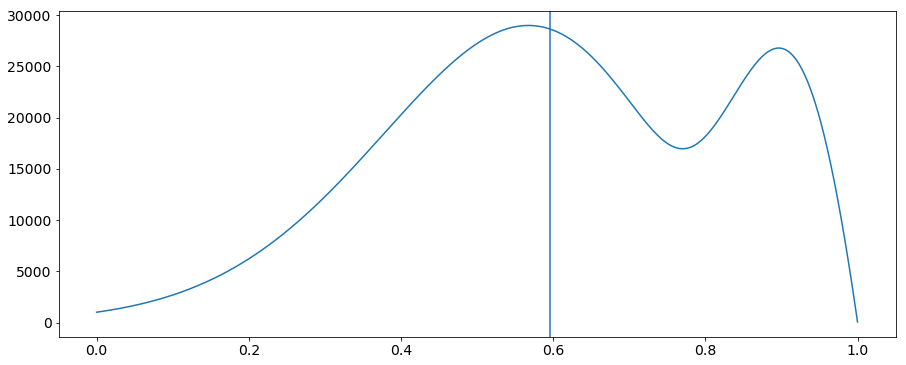

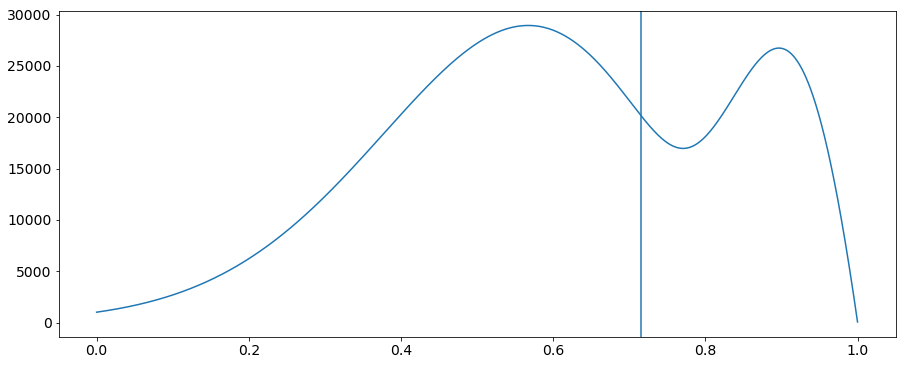

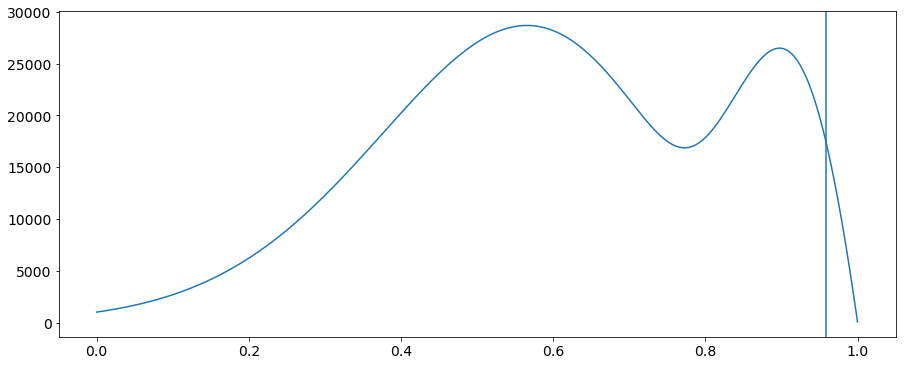

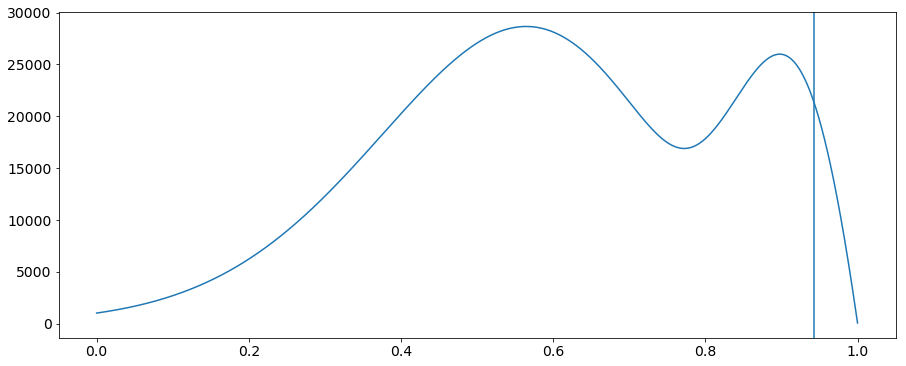

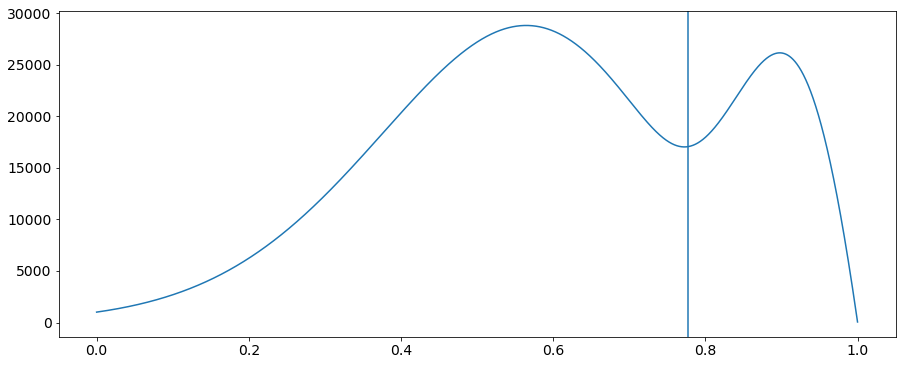

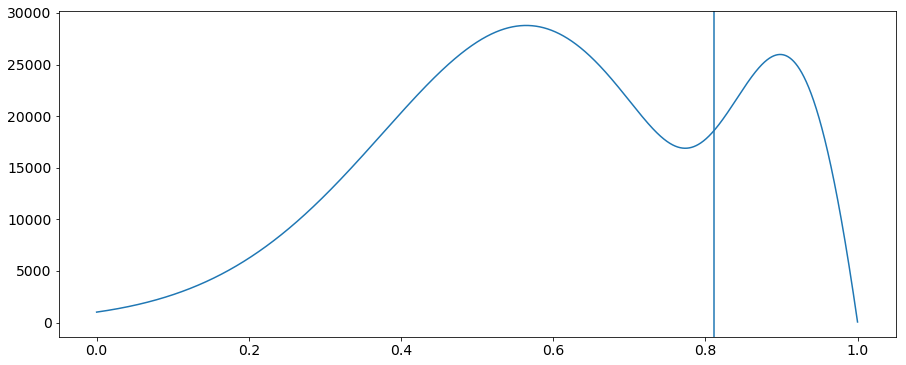

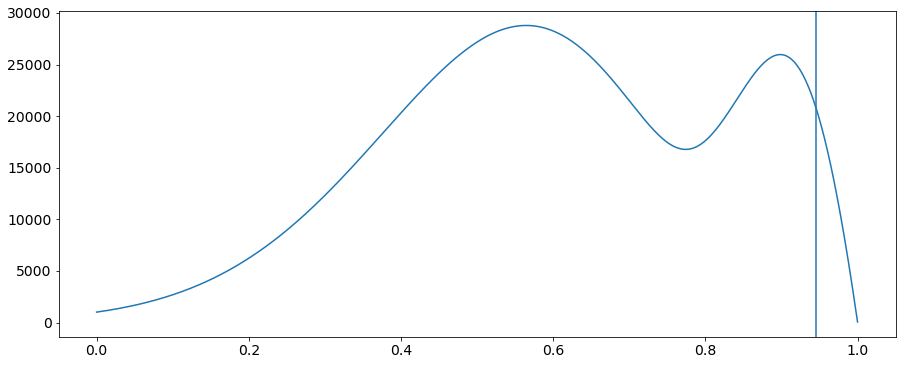

In [50]:
for k in range(np.array(bo.sigma_arr).shape[0]):
    plt.plot(np.arange(0,1,0.0001), np.array(bo.sigma_arr)[k].reshape(-1)*rho_arr)
    plt.axvline(X.T[0][1:][k])
    plt.show()

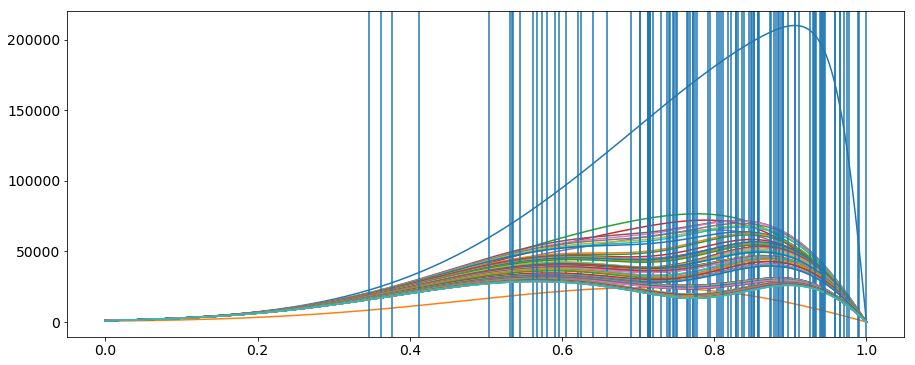

In [19]:
for k in range(np.array(bo.sigma_arr).shape[0]):
    plt.plot(np.arange(0,1,0.0001), np.array(bo.sigma_arr)[k].reshape(-1)*rho_arr)
    plt.axvline(X.T[0][1:][k])
plt.show()

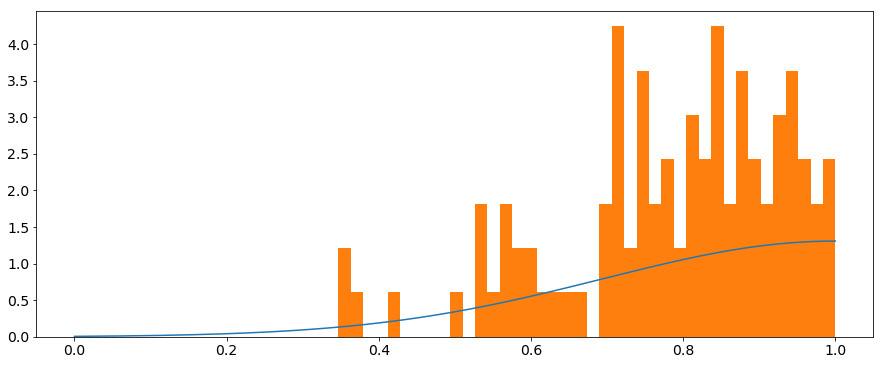

In [20]:
plt.plot(np.arange(0,1,0.0001), rho_arr)
plt.hist(X.T[0], bins = 40, label = "First_argument", normed = True)
plt.show()

In [22]:
get_prob_arr = lambda k: ss.norm.pdf(x = np.arange(0,1,0.0001), loc = hmdw.get_func().mean[k], scale = np.sqrt(cov[k][k]))
marginal_dist = margins(np.array([get_prob_arr(i) for i in range(10)]))[1]

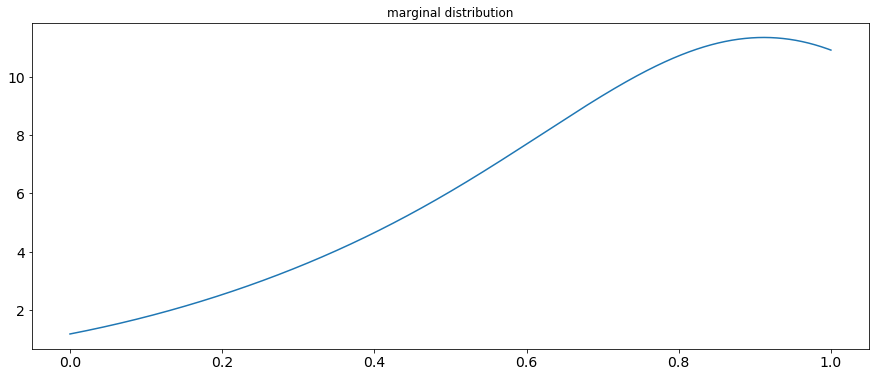

In [23]:
plt.plot(np.linspace(0,1,10000), marginal_dist[0])
plt.title('marginal distribution')
plt.show()

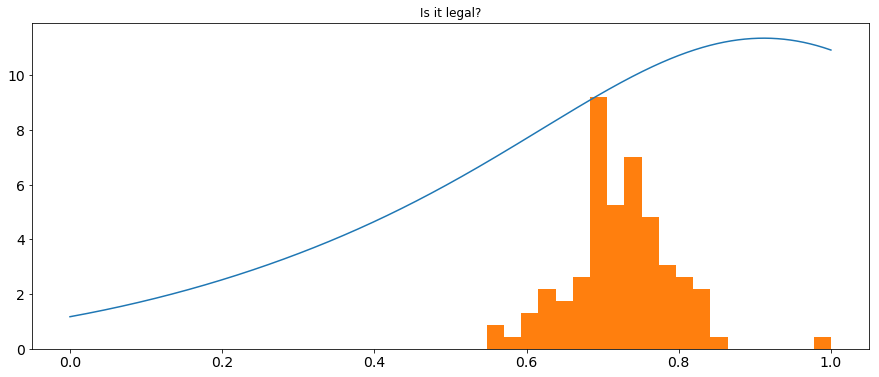

In [46]:
plt.plot(np.linspace(0,1,10000), marginal_dist[0])
plt.hist(np.sum(X.T, 0)/max(np.sum(X.T, 0)), normed = True, bins = 20)
plt.title('Is it legal?')
plt.show()